In [1]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 1000)#可显示1000行
pd.set_option("display.max_columns", 1000)#可显示1000列
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683 Assignment2")

Mounted at /content/drive/


In [3]:
df = pd.read_csv('Premier League_2014_2022.csv')
df = df[df['ranking']!='None']
df

player_id   player_name   team_id nationality     season  date_stamp  \
73            673  Scott Carson  Man City     England  2016/2017  1470492000   
75            673  Scott Carson  Man City     England  2016/2017  1471096800   
76            673  Scott Carson  Man City     England  2016/2017  1471373100   
77            673  Scott Carson  Man City     England  2016/2017  1471710600   
79            673  Scott Carson  Man City     England  2016/2017  1472237100   
...           ...           ...       ...         ...        ...         ...   
102328      15666   Teemu Pukki   Norwich     Finland  2020/2021  1619272800   
102329      15666   Teemu Pukki   Norwich     Finland  2020/2021  1619877600   
102331      15666   Teemu Pukki   Norwich     Finland  2020/2021  1623513600   
102332      15666   Teemu Pukki   Norwich     Finland  2020/2021  1623848400   
102333      15666   Teemu Pukki   Norwich     Finland  2020/2021  1624302000   

       team_host_name team_visit_name  mark1  mark2 ranking player_height  \
73       Derby County        Brighton      0      0     7.4           183   
75           Barnsley    Derby County      2      0     5.6           183   
76         Preston NE    Derby County      0      1     6.6           183   
77       Derby County     Aston Villa      0      0       7           183   
79      Burton Albion    Derby County      1      0     6.5           183   
...               ...             ...    ...    ...     ...           ...   
102328            QPR         Norwich      1      3     5.8           180   
102329        Norwich         Reading      4      1     7.4           180   
102331        Denmark         Finland      0      1     5.2           180   
102332        Finland          Russia      0      1       6           180   
102333        Finland         Belgium      0      2     5.8           180   

       player_weight  player_age  player_role_G  player_role_D  \
73                85        36.0           True          False   
75                85        36.0           True          False   
76                85        36.0           True          False   
77                85        36.0           True          False   
79                85        36.0           True          False   
...              ...         ...            ...            ...   
102328            78        31.0          False          False   
102329            78        31.0          False          False   
102331            78        31.0          False          False   
102332            78        31.0          False          False   
102333            78        31.0          False          False   

        player_role_DM  player_role_M  player_role_AM  player_role_F  
73               False          False           False          False  
75               False          False           False          False  
76               False          False           False          False  
77               False          False           False          False  
79               False          False           False          False  
...                ...            ...             ...            ...  
102328           False          False           False           True  
102329           False          False           False           True  
102331           False          False           False           True  
102332           False          False           False           True  
102333           False          False           False           True  

[63111 rows x 20 columns]

In [4]:
MOVING_AVERAGE = 5
MINIMUM_RECORD = 60
#hyper parameter
TEST_DATA_SIZE = 20
TIME_STEP = 7 
LEARNING_RATE = 0.001
EPOCHS = 500
DENSE = 1
NUM_NODES = 30

In [5]:
dict_player = {}
dict_player_name = {}
for player_id in df['player_id'].unique():
  list_rate = list(df[df['player_id']==player_id]['ranking'].astype(float).rolling(MOVING_AVERAGE).mean())
  if(len(list_rate)>=MINIMUM_RECORD):
    dict_player[player_id] = list_rate[MOVING_AVERAGE-1:]
    dict_player_name[player_id] = df[df['player_id']==player_id]['player_name'].unique()[0]

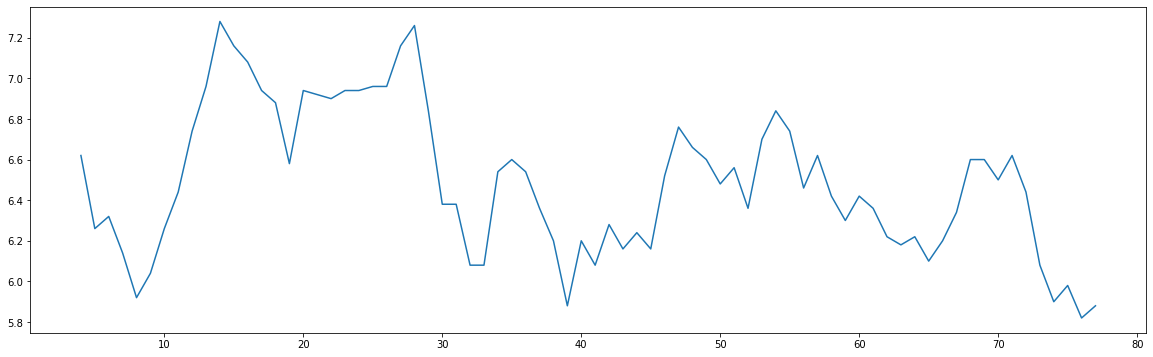

In [6]:
#Not Needed, just made a picture.
import matplotlib.pyplot as plt
df_carson = df[df['player_id']==673]
list_rate = list(df_carson['ranking'].astype(float).rolling(5).mean())
plt.figure(figsize=[20,6])
plt.plot(list_rate)

In [7]:
def create_inout_sequences(input_data, tw):
    feature_seq = []
    result_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]#预测time_step之后的第一个数值
        feature_seq.append(train_seq)#feature_seq内的数据不断更新，但是总量只有tw个
        result_seq.append(train_label)

    return feature_seq,result_seq

In [8]:
def rmsle(predicted,real):
  sum=0.0
  for x in range(len(predicted)):
    p = np.log(predicted[x]+1)
    r = np.log(real[x]+1)
    sum = sum + (p - r)**2
  return (sum/len(predicted))**0.5

In [9]:
len(dict_player.keys())

396

In [10]:
#RESULT FILENAME
Filename = 'LSTM_result1.csv'
Foldername = 'LSTM_result1'

In [11]:
#初始化文件，更换文件名称后的第一次点（做一个空文件），做的过程中千万不要点，点了就清空了。
df_result = pd.DataFrame(columns = ['name','id','mae','mse','rmsle','r2'],dtype = float)
df_result['name'] = df_result['name'].astype('string')
df_result['id'] = df_result['id'].astype('int')
df_result.to_csv(Filename,index=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/396 [00:00<?, ?it/s]

Read File......
Current Length:0
Now working on player: Scott Carson
Data size:67
	mae:0.20138675022125244
	mse:0.05445285570442313
	r2:0.04231773853878629
	rmsle:[0.03220359]
Read File......
Current Length:1
Now working on player: Ederson
Data size:195
	mae:0.12812326049804706
	mse:0.027579894830521957
	r2:0.3379130298031022
	rmsle:[0.02152434]
Read File......
Current Length:2
Now working on player: Kyle Walker
Data size:255
	mae:0.1313263511657717
	mse:0.027441257913020232
	r2:0.18707021231721055
	rmsle:[0.02110949]
Read File......
Current Length:3
Now working on player: João Cancelo
Data size:199
	mae:0.1565121011734009
	mse:0.04312146417041082
	r2:-0.21182172241487152
	rmsle:[0.02476575]
Read File......
Current Length:4
Now working on player: Benjamin Mendy
Data size:147
	mae:0.1897965097427367
	mse:0.06036468922711942
	r2:-0.5833776420921053
	rmsle:[0.03221314]
Read File......
Current Length:5
Now working on player: Oleksandr Zinchenko
Data size:138
	mae:0.20962721729278555
	mse:0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.18934765911102364
	mse:0.05937982471874674
	r2:0.6921347149528883
	rmsle:[0.03127861]
Read File......
Current Length:21
Now working on player: Loris Karius
Data size:102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.24794223022460932
	mse:0.07251146431243108
	r2:-1.342404196680159
	rmsle:[0.03661973]
Read File......
Current Length:22
Now working on player: Adrián
Data size:78


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.24067522907257083
	mse:0.08906624900256761
	r2:-1.2169018568938577
	rmsle:[0.04088899]
Read File......
Current Length:23
Now working on player: Trent Alexander-Arnold
Data size:159


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1315057306289673
	mse:0.02828867154453506
	r2:-0.18660535002244294
	rmsle:[0.02060914]
Read File......
Current Length:24
Now working on player: Kostas Tsimikas
Data size:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.150164340019226
	mse:0.037182249366933824
	r2:0.3281004469373523
	rmsle:[0.02530843]
Read File......
Current Length:25
Now working on player: Joe Gomez
Data size:97


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2124240398406981
	mse:0.06966100608867648
	r2:0.4881292217069719
	rmsle:[0.03419095]
Read File......
Current Length:26
Now working on player: Ibrahima Konaté
Data size:79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.26811282348632826
	mse:0.10681781205242977
	r2:0.24382123706335979
	rmsle:[0.0440514]
Read File......
Current Length:27
Now working on player: Joël Matip
Data size:95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.15618943500518806
	mse:0.034264442792865064
	r2:0.5794483854818653
	rmsle:[0.02307852]
Read File......
Current Length:28
Now working on player: Andrew Robertson
Data size:220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.13422154331207253
	mse:0.031859182796059975
	r2:0.4666937378252055
	rmsle:[0.02240194]
Read File......
Current Length:29
Now working on player: Virgil van Dijk
Data size:208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.20578170204162588
	mse:0.05956288470327988
	r2:0.2804589968074036
	rmsle:[0.0303624]
Read File......
Current Length:30
Now working on player: Thiago Alcântara
Data size:186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.19974437904357925
	mse:0.06282434661883121
	r2:0.42487507214809095
	rmsle:[0.0314235]
Read File......
Current Length:31
Now working on player: Luis Díaz
Data size:75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.3099074592590332
	mse:0.1368346206367828
	r2:0.44049565497463716
	rmsle:[0.04855924]
Read File......
Current Length:32
Now working on player: Jordan Henderson
Data size:194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.19608362483978267
	mse:0.05063444700845178
	r2:0.6943766930125558
	rmsle:[0.02760925]
Read File......
Current Length:33
Now working on player: Naby Keïta
Data size:119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.347534805297852
	mse:0.13342779600250018
	r2:-0.8904744471089172
	rmsle:[0.04684728]
Read File......
Current Length:34
Now working on player: James Milner
Data size:185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.12122874450683585
	mse:0.022566792458225095
	r2:0.7350195803599512
	rmsle:[0.01921238]
Read File......
Current Length:35
Now working on player: Alex Oxlade-Chamberlain
Data size:115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2548427953720095
	mse:0.08390543420577143
	r2:-0.3625657156785831
	rmsle:[0.03948777]
Read File......
Current Length:36
Now working on player: Fabinho
Data size:268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.12446004104614179
	mse:0.02554655495315276
	r2:0.6585780638143808
	rmsle:[0.02042711]
Read File......
Current Length:37
Now working on player: Takumi Minamino
Data size:125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.19716679477691654
	mse:0.048245120727403064
	r2:0.6132066549021253
	rmsle:[0.02919563]
Read File......
Current Length:38
Now working on player: Sadio Mané
Data size:237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.19894226837158202
	mse:0.054325398760016144
	r2:0.11028024107803758
	rmsle:[0.02962756]
Read File......
Current Length:39
Now working on player: Mohamed Salah
Data size:281


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1590832481384275
	mse:0.04267141978278624
	r2:0.36886867842826987
	rmsle:[0.02630487]
Read File......
Current Length:40
Now working on player: Roberto Firmino
Data size:266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.15212943077087412
	mse:0.030859068932407207
	r2:0.7795402859603989
	rmsle:[0.02232438]
Read File......
Current Length:41
Now working on player: Divock Origi
Data size:103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.14586223411560068
	mse:0.02814533813511621
	r2:0.5887829738893663
	rmsle:[0.02360022]
Read File......
Current Length:42
Now working on player: Diogo Jota
Data size:112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.21910229301452638
	mse:0.07217434352627924
	r2:0.6931049787126271
	rmsle:[0.03525647]
Read File......
Current Length:43
Now working on player: Kepa Arrizabalaga
Data size:153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2352240686416625
	mse:0.0747772413103073
	r2:0.7748561823187016
	rmsle:[0.03691004]
Read File......
Current Length:44
Now working on player: Marcus Bettinelli
Data size:61


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.22420910549163797
	mse:0.06830394366574695
	r2:0.22993558365092104
	rmsle:[0.03777603]
Read File......
Current Length:45
Now working on player: Edouard Mendy
Data size:145


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.172136245727539
	mse:0.049285959690133
	r2:0.30539130871491726
	rmsle:[0.02847664]
Read File......
Current Length:46
Now working on player: Trevoh Chalobah
Data size:93


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.27006415748596196
	mse:0.11666920518244799
	r2:-0.024168731191825277
	rmsle:[0.04460126]
Read File......
Current Length:47
Now working on player: Antonio Rüdiger
Data size:202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.12162342262268071
	mse:0.02252128168235006
	r2:0.4805378460996419
	rmsle:[0.01864874]
Read File......
Current Length:48
Now working on player: Malang Sarr
Data size:105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.12540964221954343
	mse:0.023705416313872327
	r2:0.4297607391240925
	rmsle:[0.02006755]
Read File......
Current Length:49
Now working on player: Cesar Azpilicueta
Data size:257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.14978289508819573
	mse:0.029040177999473116
	r2:0.5185247782562689
	rmsle:[0.0221071]
Read File......
Current Length:50
Now working on player: Ben Chilwell
Data size:146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2274251699447633
	mse:0.08069442070354457
	r2:0.7092302511402979
	rmsle:[0.03526816]
Read File......
Current Length:51
Now working on player: Andreas Christensen
Data size:168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1459533262252808
	mse:0.03148588225538483
	r2:0.6778311666166839
	rmsle:[0.02242702]
Read File......
Current Length:52
Now working on player: Thiago Silva
Data size:222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.14067752075195322
	mse:0.0338392921997075
	r2:0.5420934749701292
	rmsle:[0.02210872]
Read File......
Current Length:53
Now working on player: Callum Hudson-Odoi
Data size:61


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.13361721324920653
	mse:0.02467675469663079
	r2:0.7938983663660137
	rmsle:[0.02024147]
Read File......
Current Length:54
Now working on player: Marcos Alonso
Data size:199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1289513397216795
	mse:0.022800063179465542
	r2:-0.0798040814333647
	rmsle:[0.01955671]
Read File......
Current Length:55
Now working on player: Jorginho
Data size:265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.10556165409088143
	mse:0.018430465287613742
	r2:0.5890734813579683
	rmsle:[0.01685464]
Read File......
Current Length:56
Now working on player: Reece James
Data size:108


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.10748531246185303
	mse:0.019001807456771838
	r2:0.660172268102657
	rmsle:[0.01761681]
Read File......
Current Length:57
Now working on player: N'Golo Kanté
Data size:284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.13877863597869866
	mse:0.0304646136779002
	r2:0.7718758335986626
	rmsle:[0.0215618]
Read File......
Current Length:58
Now working on player: Mateo Kovačić
Data size:205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.17651120758056676
	mse:0.04592841406411211
	r2:0.6860475759676801
	rmsle:[0.02586094]
Read File......
Current Length:59
Now working on player: Ruben Loftus-Cheek
Data size:84


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.14894730949401852
	mse:0.032614010269602395
	r2:-0.11864209465279907
	rmsle:[0.02481602]
Read File......
Current Length:60
Now working on player: Saul Niguez
Data size:266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1438386383056638
	mse:0.03023772712874214
	r2:0.5786504775550114
	rmsle:[0.02334097]
Read File......
Current Length:61
Now working on player: Kenedy
Data size:98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.14394370174407953
	mse:0.0303597762917506
	r2:0.22122470008848472
	rmsle:[0.02370258]
Read File......
Current Length:62
Now working on player: Ross Barkley
Data size:165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1434262647628785
	mse:0.027222673726054563
	r2:0.7844875255228587
	rmsle:[0.02203491]
Read File......
Current Length:63
Now working on player: Mason Mount
Data size:184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.197581977844239
	mse:0.056643152878806266
	r2:-0.5211932774413539
	rmsle:[0.03004212]
Read File......
Current Length:64
Now working on player: Christian Pulisic
Data size:165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.16298482418060306
	mse:0.047082645799962394
	r2:0.45344254039791076
	rmsle:[0.02813208]
Read File......
Current Length:65
Now working on player: Hakim Ziyech
Data size:248


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.34738958930969227
	mse:0.14572878231137287
	r2:-3.1901372181883563
	rmsle:[0.05023471]
Read File......
Current Length:66
Now working on player: Timo Werner
Data size:213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.21330822658538806
	mse:0.05760814680353739
	r2:0.1399715334477284
	rmsle:[0.03242663]
Read File......
Current Length:67
Now working on player: Kai Havertz
Data size:178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.17606151199340783
	mse:0.04614827075096778
	r2:0.27094787040920354
	rmsle:[0.02752116]
Read File......
Current Length:68
Now working on player: Romelu Lukaku
Data size:276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.19480073451995844
	mse:0.07226893157259597
	r2:0.5737251582401621
	rmsle:[0.03289129]
Read File......
Current Length:69
Now working on player: David De Gea
Data size:253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.23120392036437987
	mse:0.07062013233745407
	r2:0.38022070194609536
	rmsle:[0.03489874]
Read File......
Current Length:70
Now working on player: Tom Heaton
Data size:67


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2218863697052001
	mse:0.06545632722339383
	r2:0.08293646010712541
	rmsle:[0.03499197]
Read File......
Current Length:71
Now working on player: Dean Henderson
Data size:101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1853770399093627
	mse:0.05676450221002862
	r2:-0.2586643209390156
	rmsle:[0.03080359]
Read File......
Current Length:72
Now working on player: Diogo Dalot
Data size:52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1275519828796387
	mse:0.031185177542871124
	r2:-0.16956111396906537
	rmsle:[0.02340496]
Read File......
Current Length:73
Now working on player: Aaron Wan-Bissaka
Data size:132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1264045953750609
	mse:0.02677342546822578
	r2:0.6959327495630281
	rmsle:[0.02044232]
Read File......
Current Length:74
Now working on player: Luke Shaw
Data size:148


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.163770378112793
	mse:0.037400991461430416
	r2:0.6151527878927561
	rmsle:[0.02503514]
Read File......
Current Length:75
Now working on player: Alex Telles
Data size:167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.21991477680206262
	mse:0.08013787305951975
	r2:0.602212494554625
	rmsle:[0.03739214]
Read File......
Current Length:76
Now working on player: Eric Bailly
Data size:119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.23734871101379373
	mse:0.07954560257436294
	r2:0.2992564697984169
	rmsle:[0.03692145]
Read File......
Current Length:77
Now working on player: Phil Jones
Data size:74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2317533855438228
	mse:0.07170601065534712
	r2:-1.2433365866395714
	rmsle:[0.03362508]
Read File......
Current Length:78
Now working on player: Victor Lindelof
Data size:177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1769114017486572
	mse:0.04689486695022317
	r2:0.04333285154280675
	rmsle:[0.02743848]
Read File......
Current Length:79
Now working on player: Harry Maguire
Data size:225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.15118955898284922
	mse:0.03343237863844068
	r2:0.5606725628662572
	rmsle:[0.02238372]
Read File......
Current Length:80
Now working on player: Raphaël Varane
Data size:245


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1265142917633058
	mse:0.0250424843304018
	r2:0.5327546023882039
	rmsle:[0.01950512]
Read File......
Current Length:81
Now working on player: Fred
Data size:129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.15751042938232426
	mse:0.03335313711901372
	r2:0.6286503839069466
	rmsle:[0.02291851]
Read File......
Current Length:82
Now working on player: Nemanja Matić
Data size:206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1407106552124024
	mse:0.027281840802531498
	r2:0.6607200407589575
	rmsle:[0.02094165]
Read File......
Current Length:83
Now working on player: Scott McTominay
Data size:111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1505292720794679
	mse:0.0327582898215034
	r2:-0.24560971221351813
	rmsle:[0.02321768]
Read File......
Current Length:84
Now working on player: Paul Pogba
Data size:243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.1425957307815552
	mse:0.03121827996101375
	r2:0.5127853303002146
	rmsle:[0.02185031]
Read File......
Current Length:85
Now working on player: Mason Greenwood
Data size:74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.23076488876342757
	mse:0.07257334883637134
	r2:0.6543533708808587
	rmsle:[0.03469914]
Read File......
Current Length:86
Now working on player: Marcus Rashford
Data size:239


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.17322441482543954
	mse:0.03798893682643846
	r2:0.6831509239137378
	rmsle:[0.02622704]
Read File......
Current Length:87
Now working on player: Jadon Sancho
Data size:129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.22213821983337395
	mse:0.07189356723364508
	r2:-0.4585536352203261
	rmsle:[0.03034339]
Read File......
Current Length:88
Now working on player: Bruno Fernandes
Data size:285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.2025906944274904
	mse:0.06029638721573383
	r2:0.7156514837669532
	rmsle:[0.02957791]
Read File......
Current Length:89
Now working on player: Jesse Lingard
Data size:173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	mae:0.34600982093811056
	mse:0.18849820579391005
	r2:0.4275025943523886
	rmsle:[0.05195027]
Read File......
Current Length:90
Now working on player: Juan Mata
Data size:167


KeyboardInterrupt: ignored

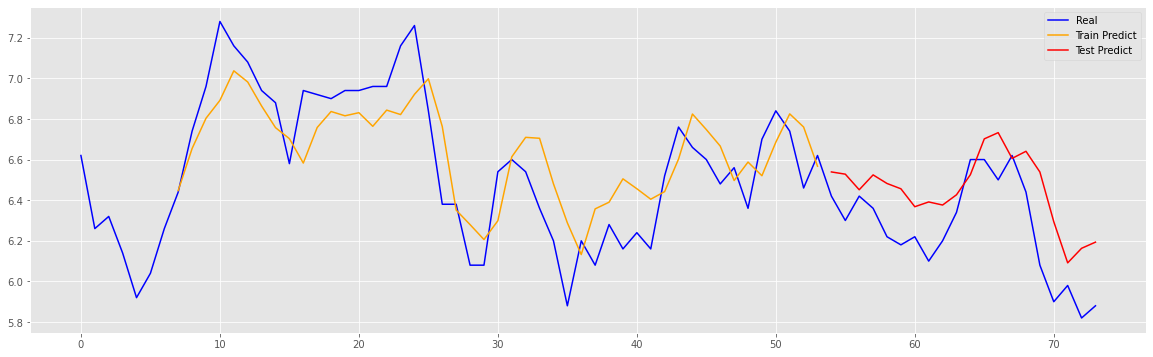

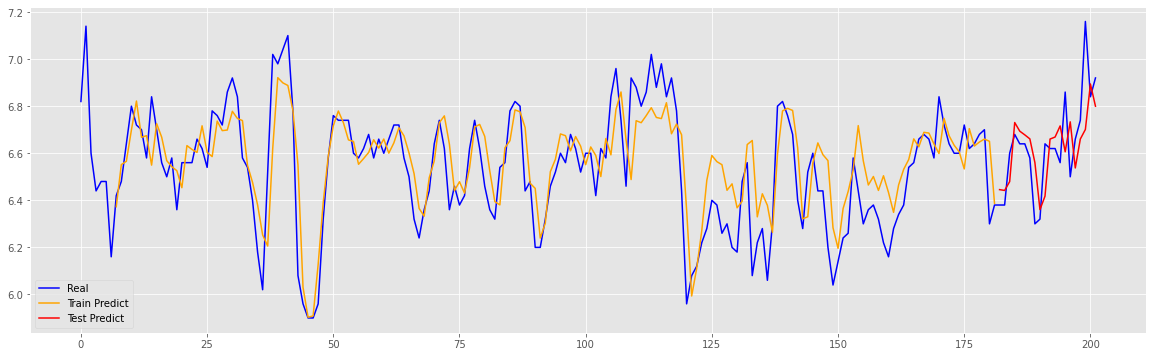

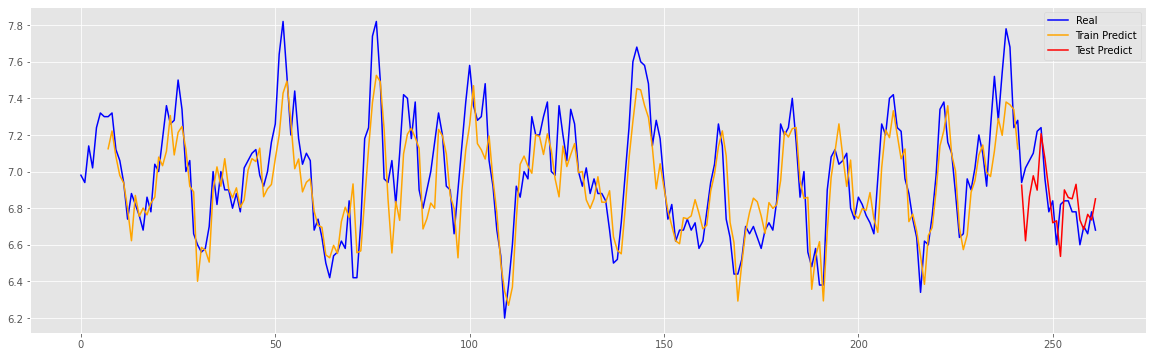

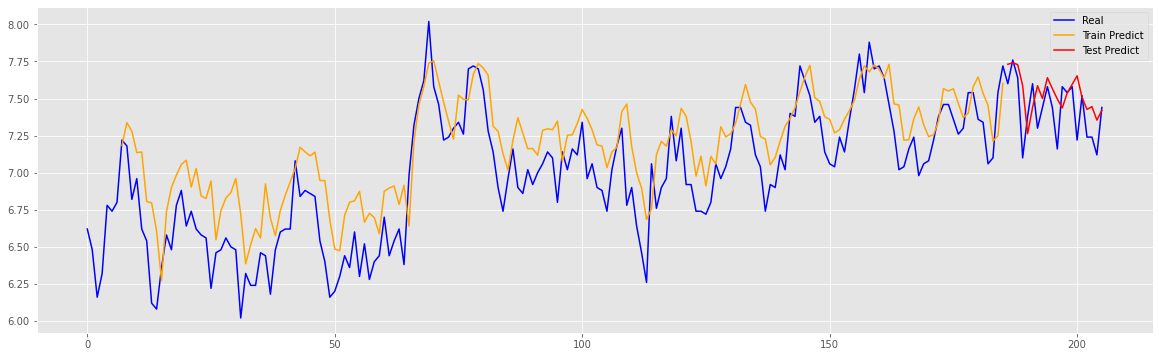

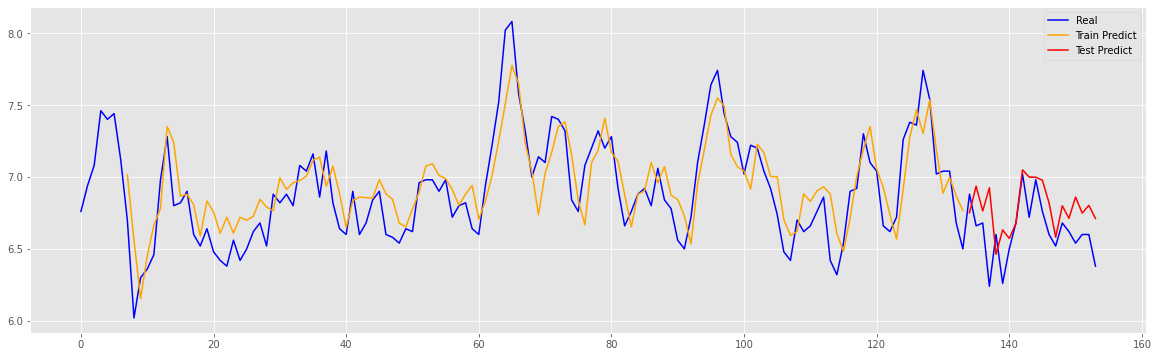

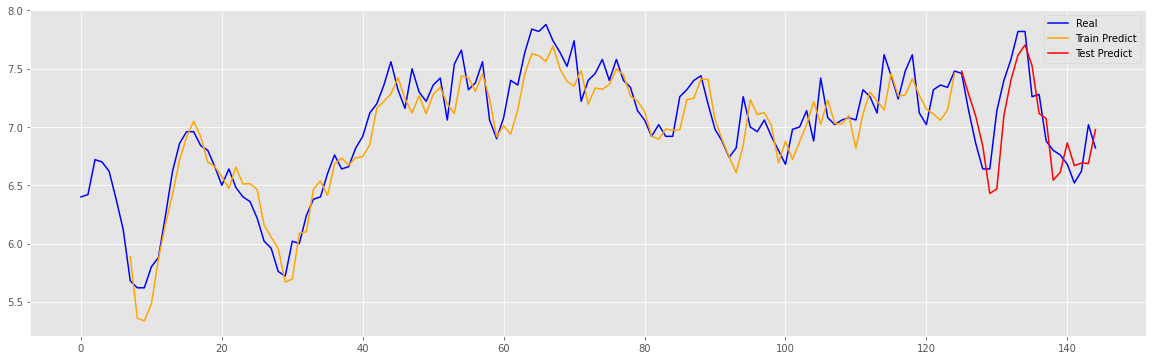

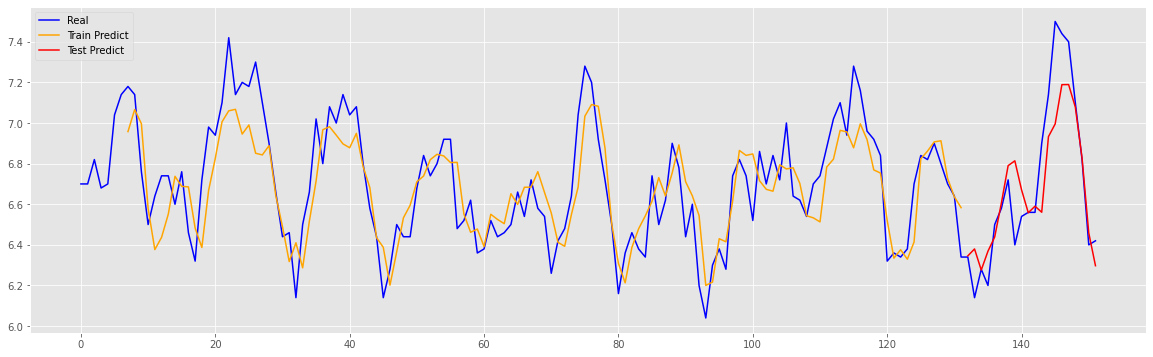

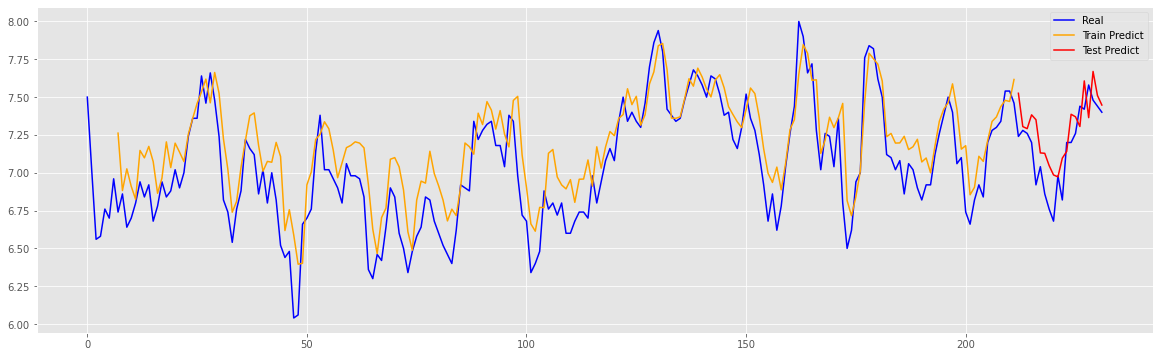

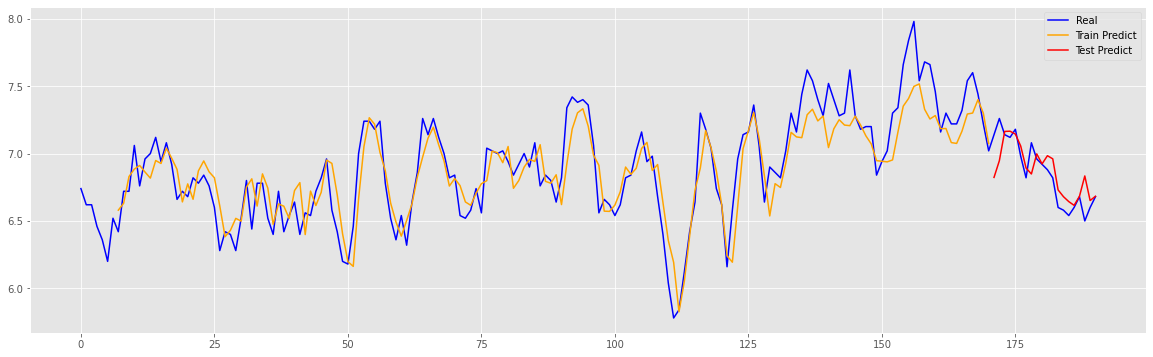

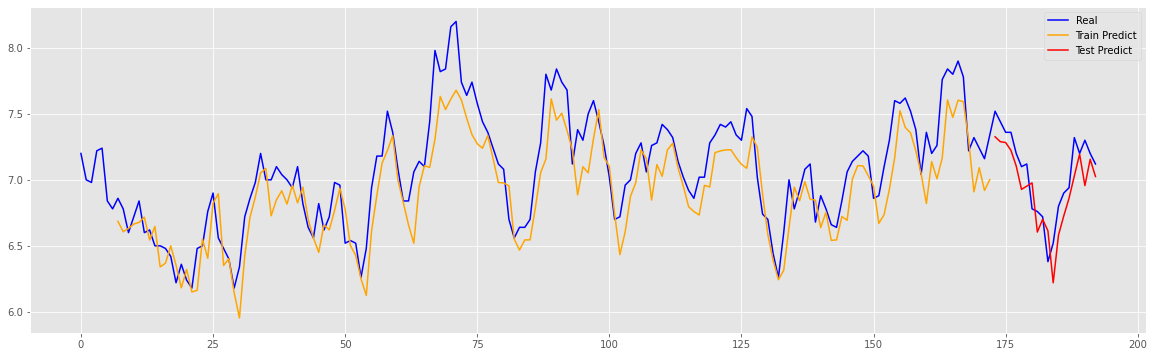

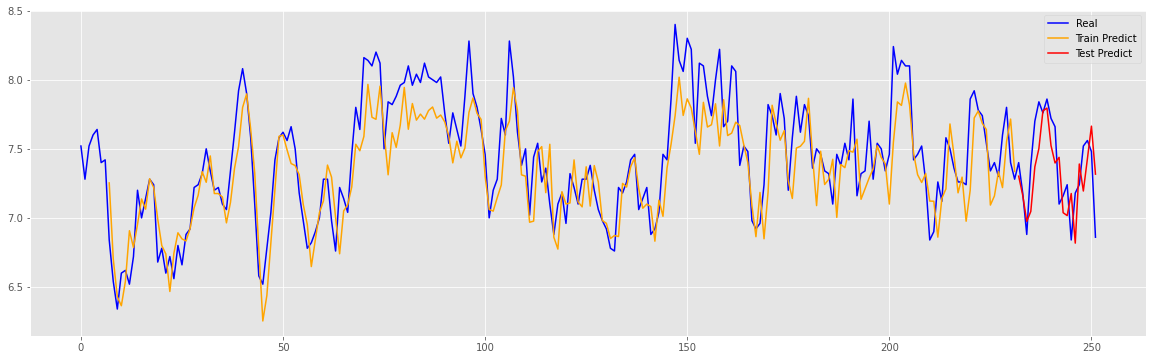

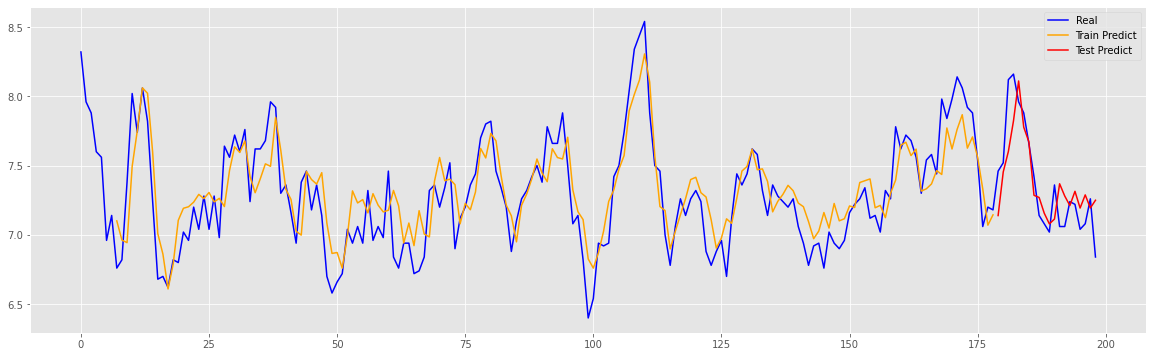

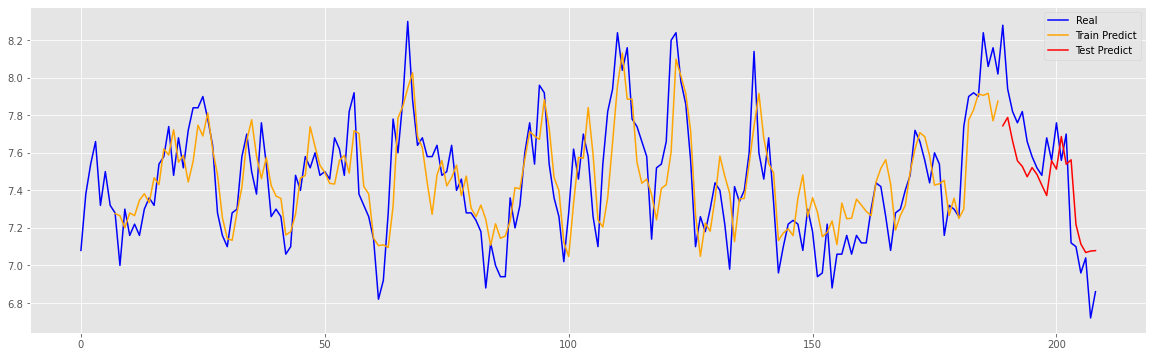

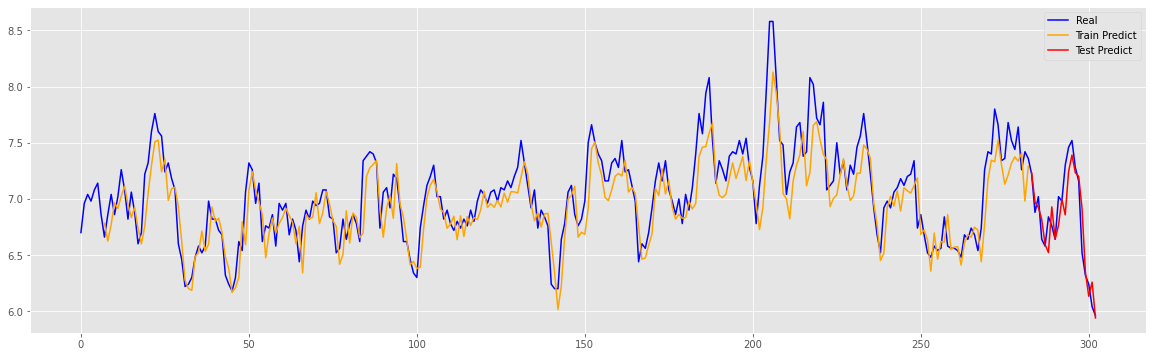

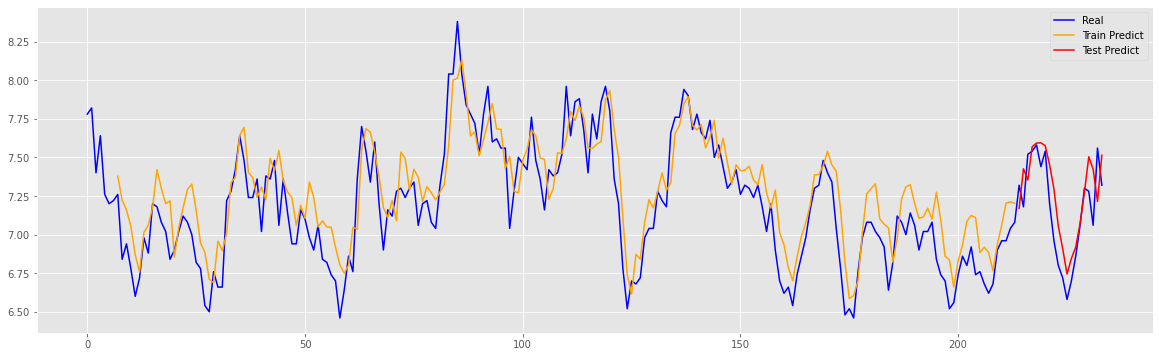

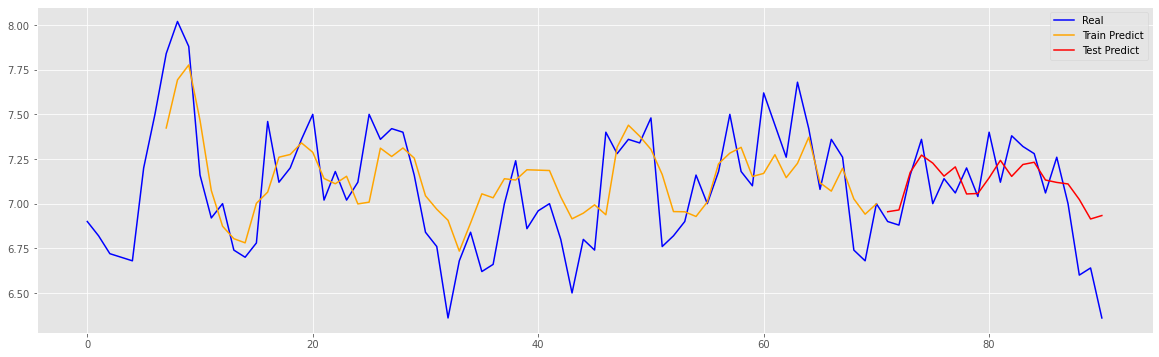

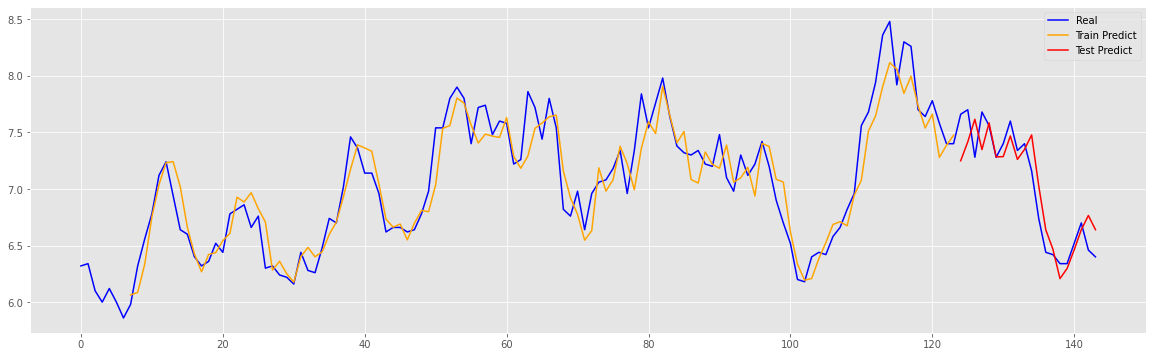

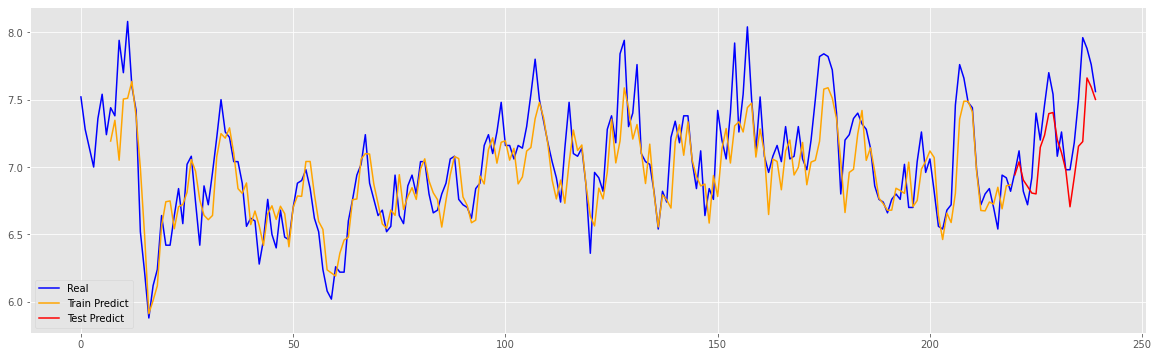

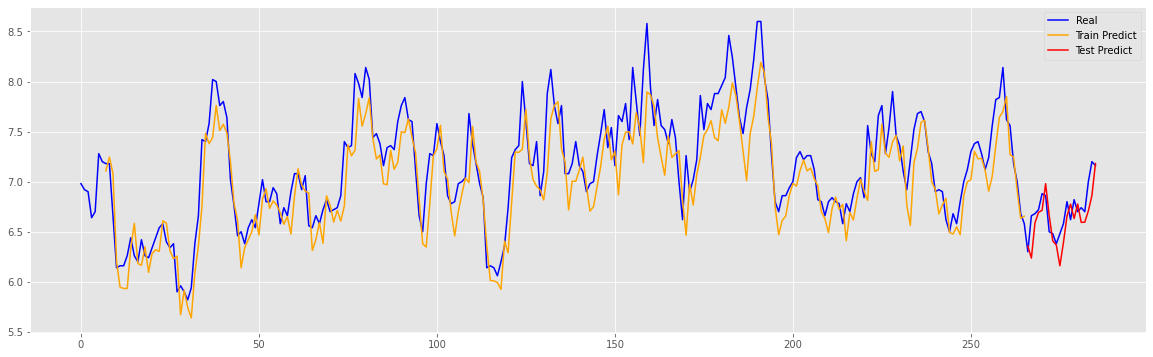

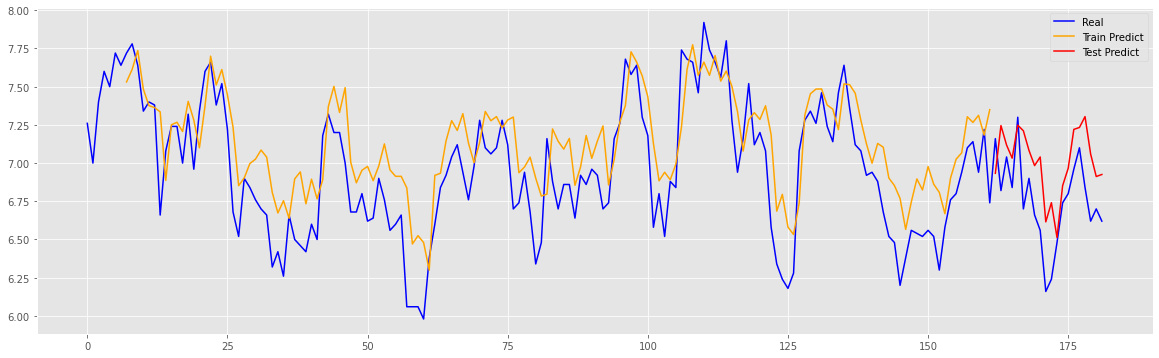

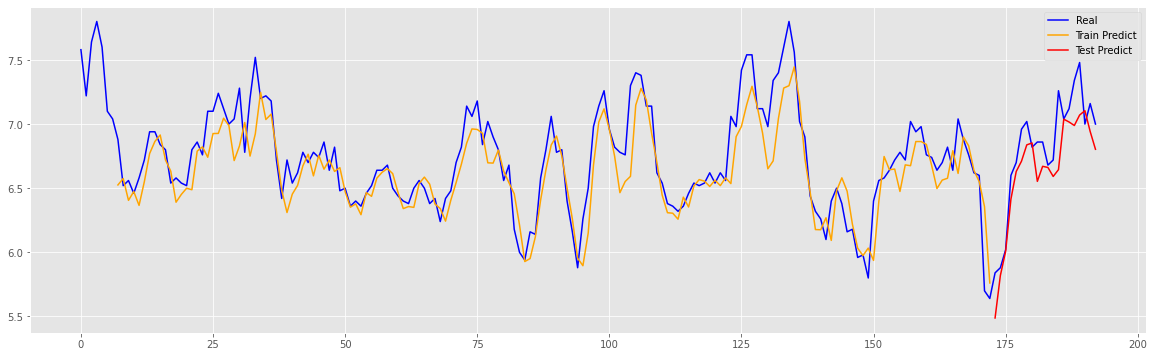

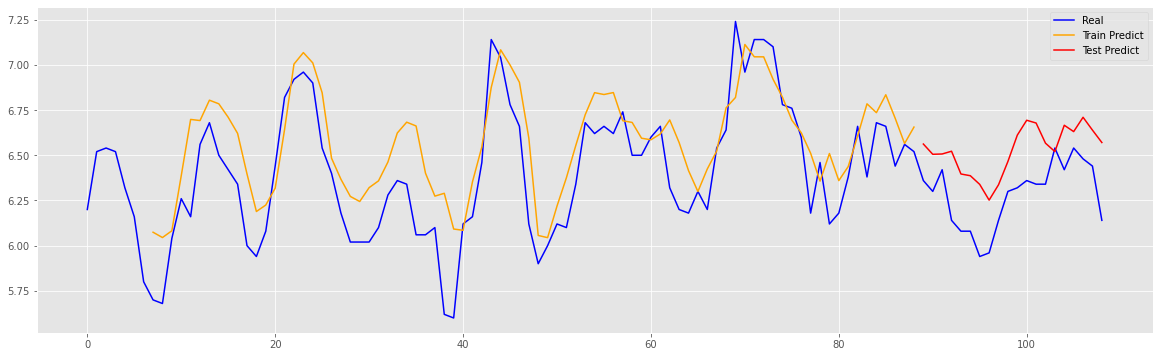

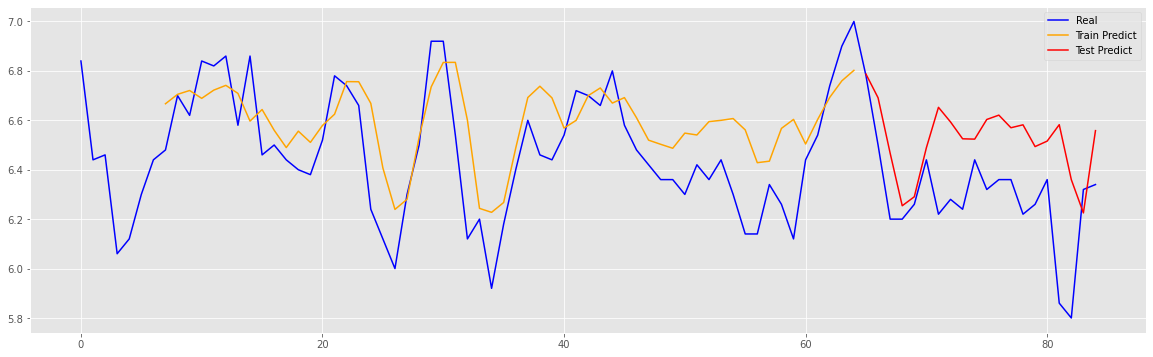

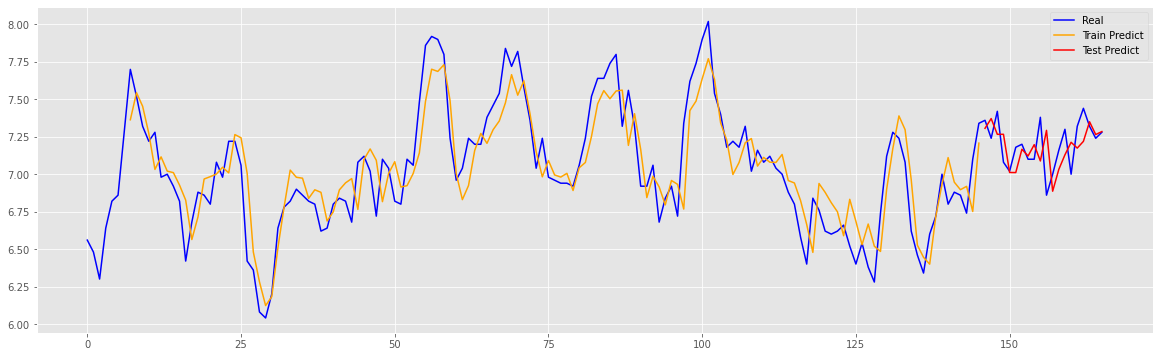

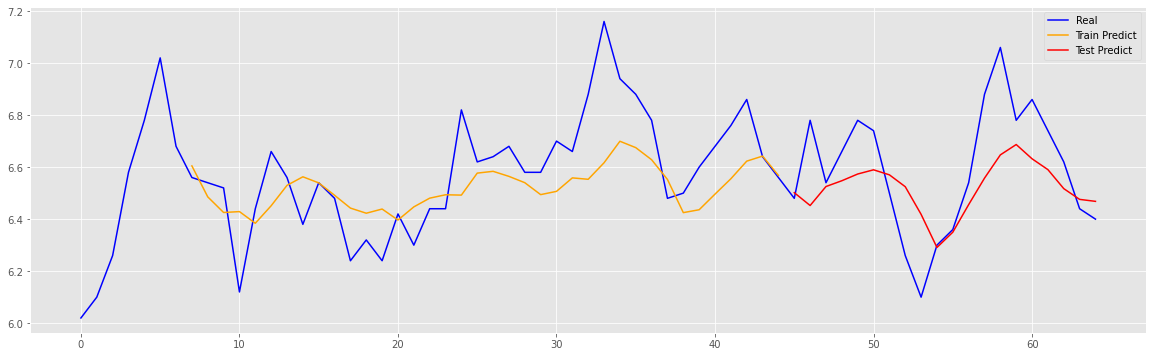

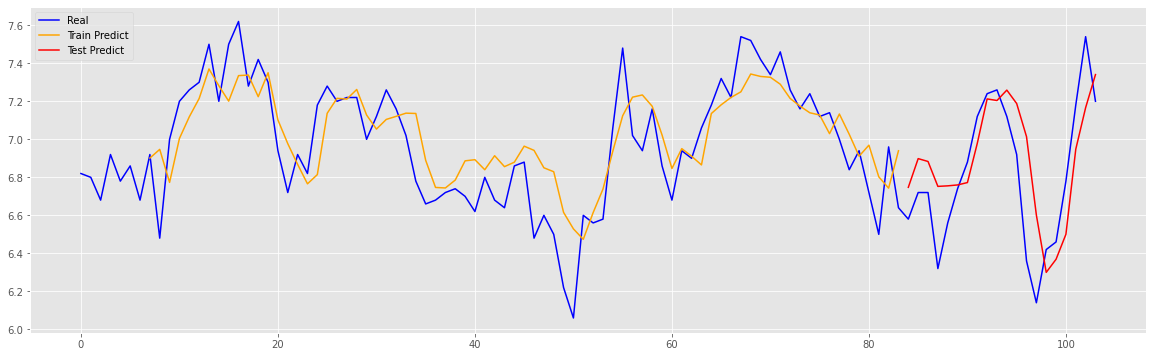

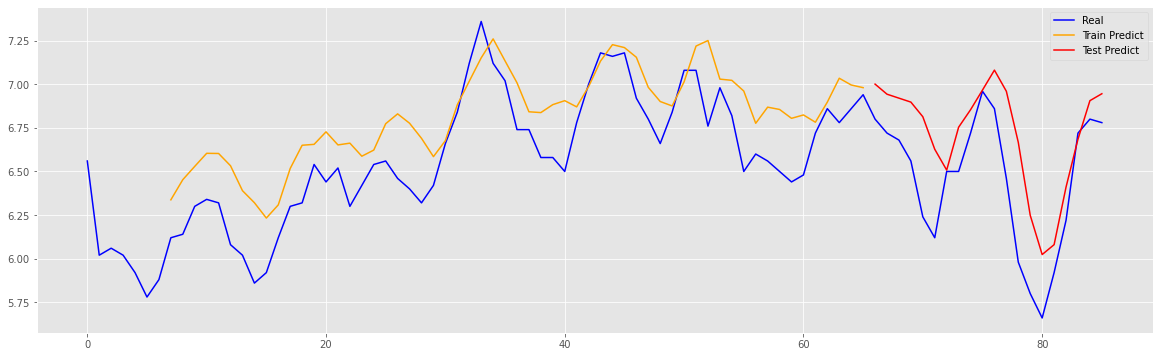

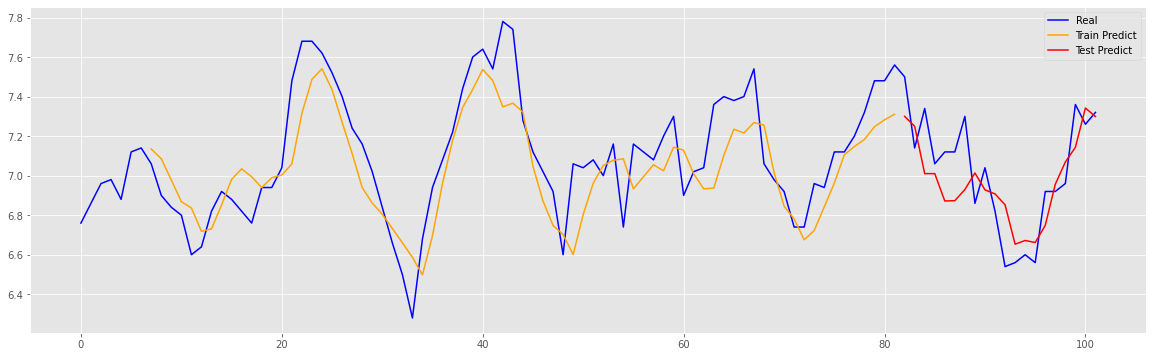

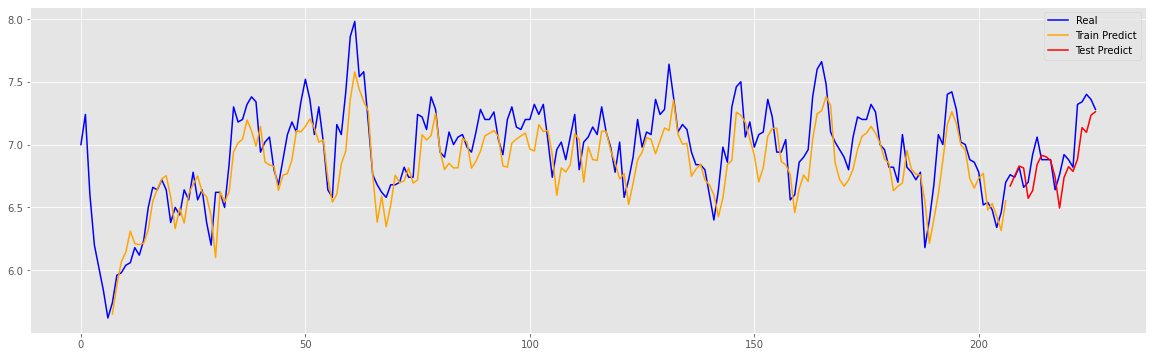

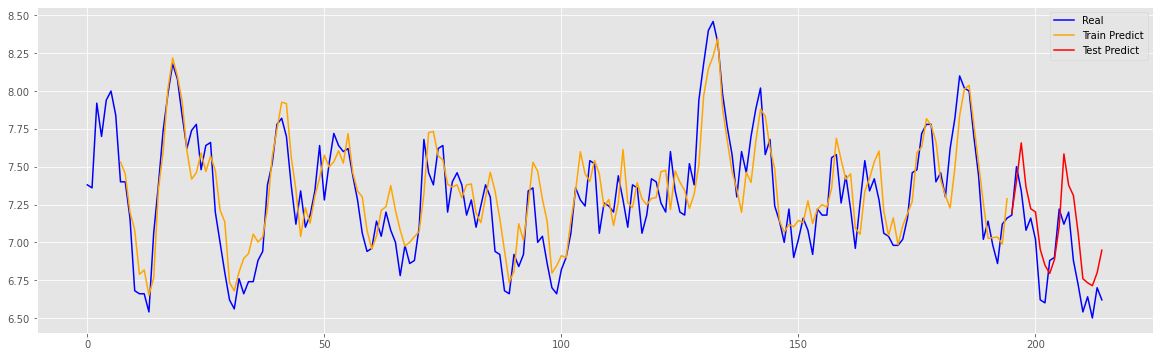

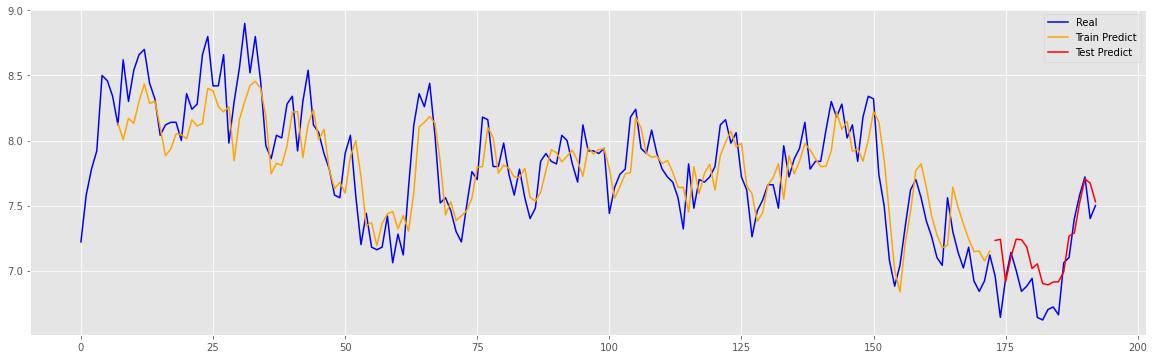

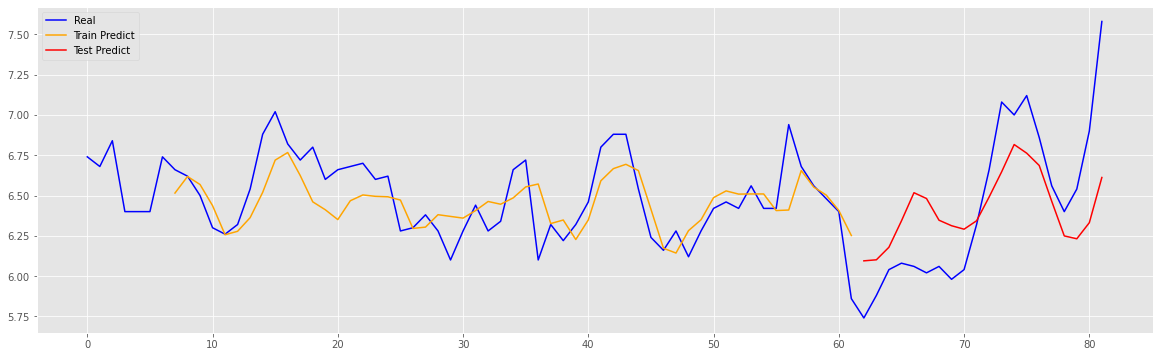

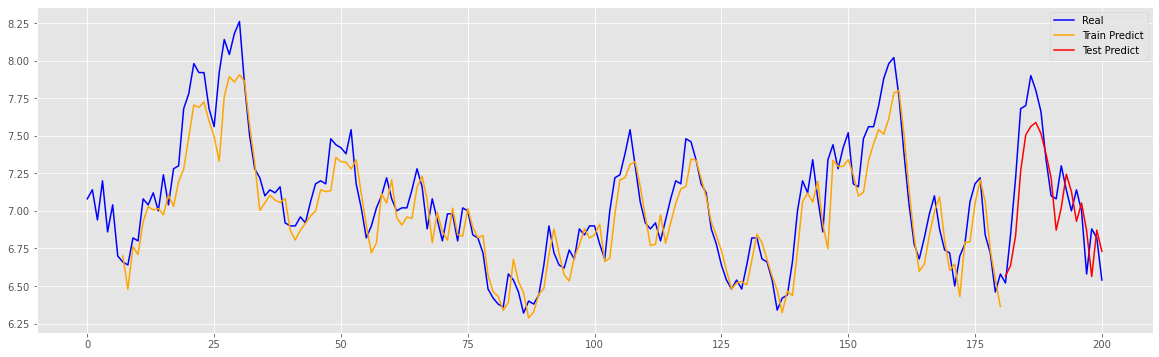

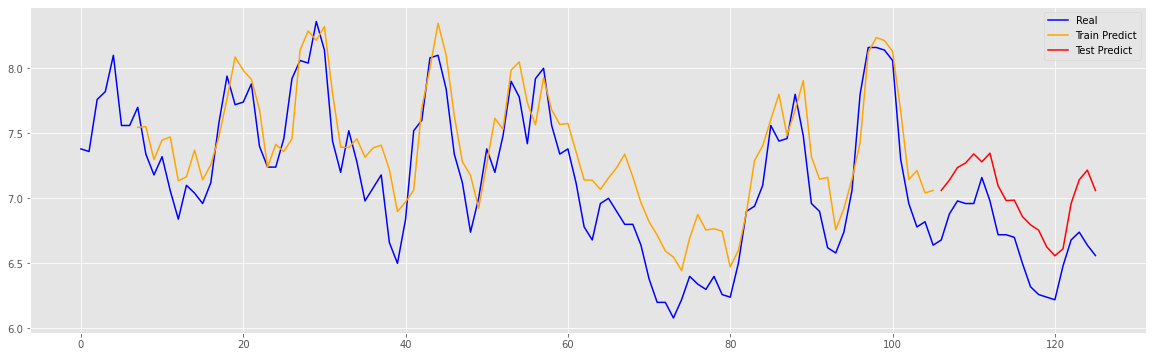

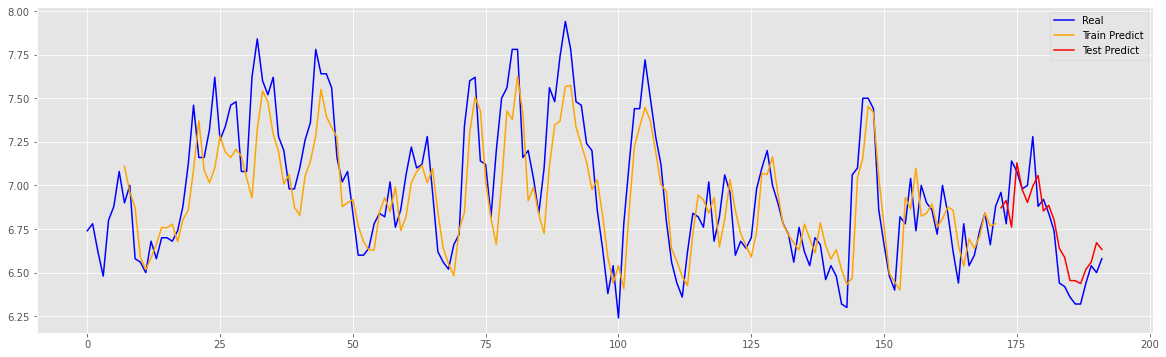

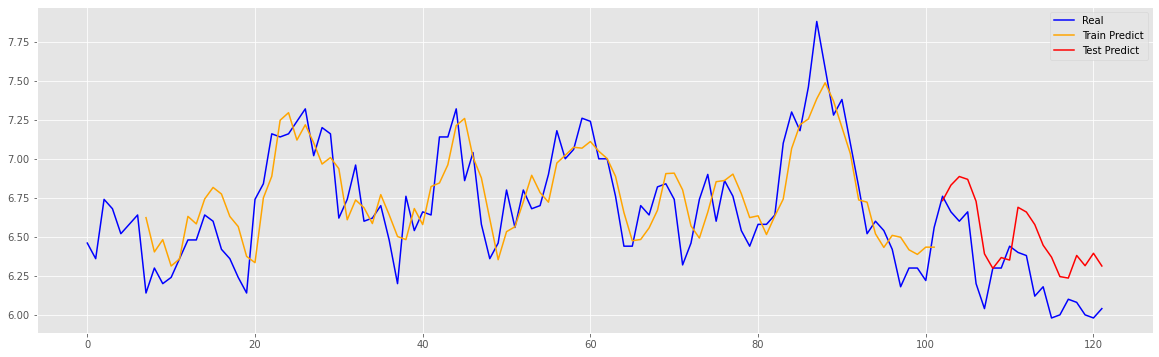

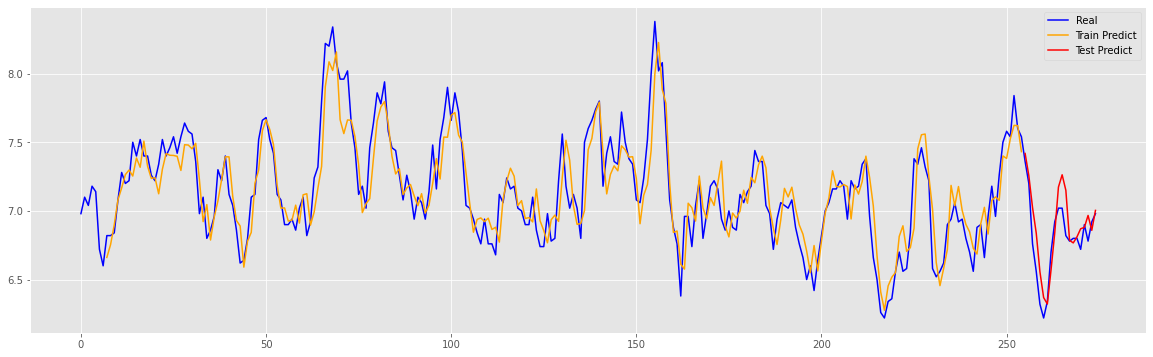

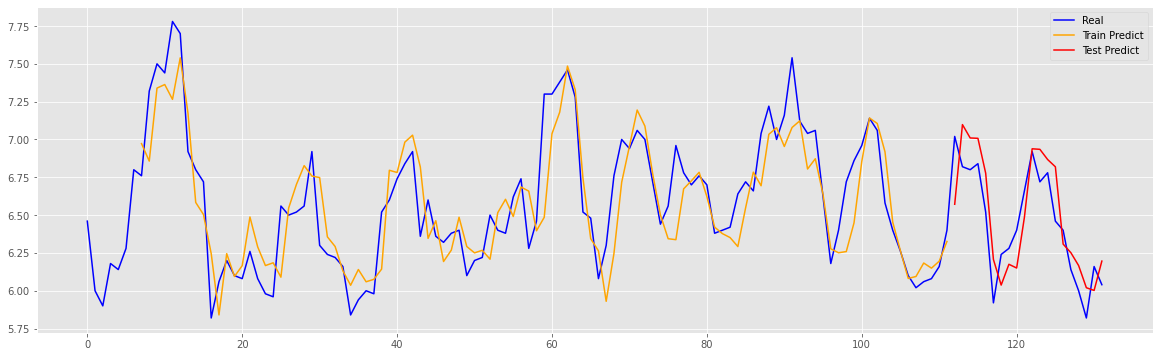

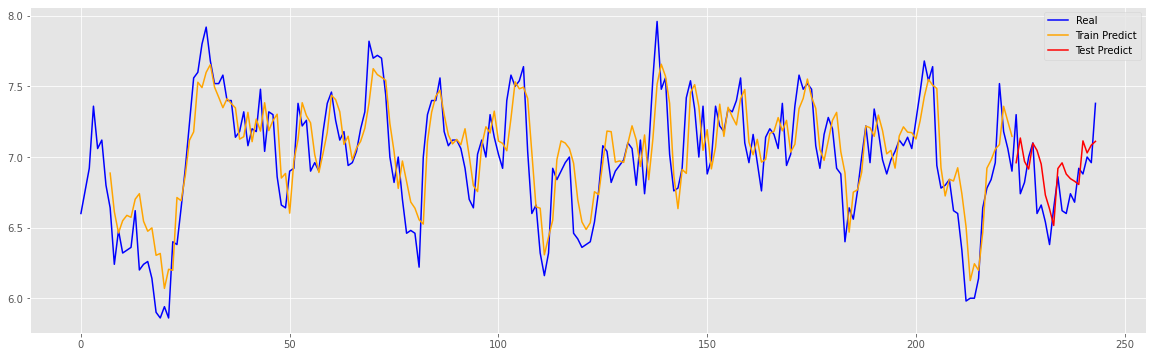

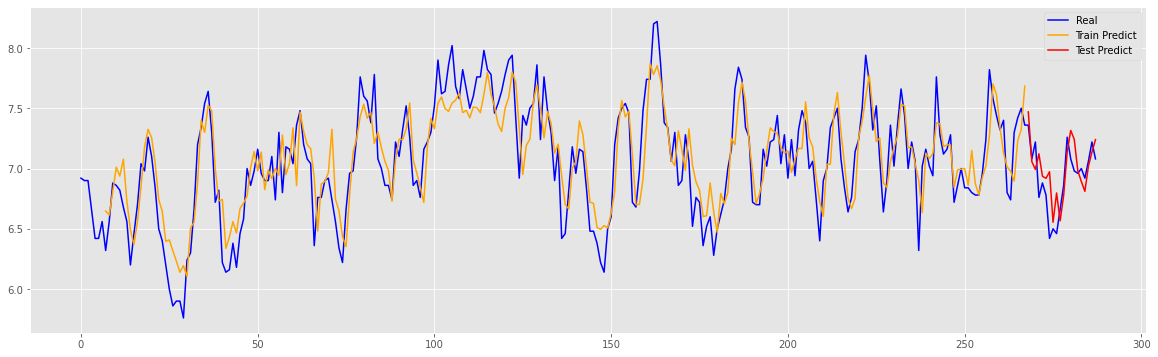

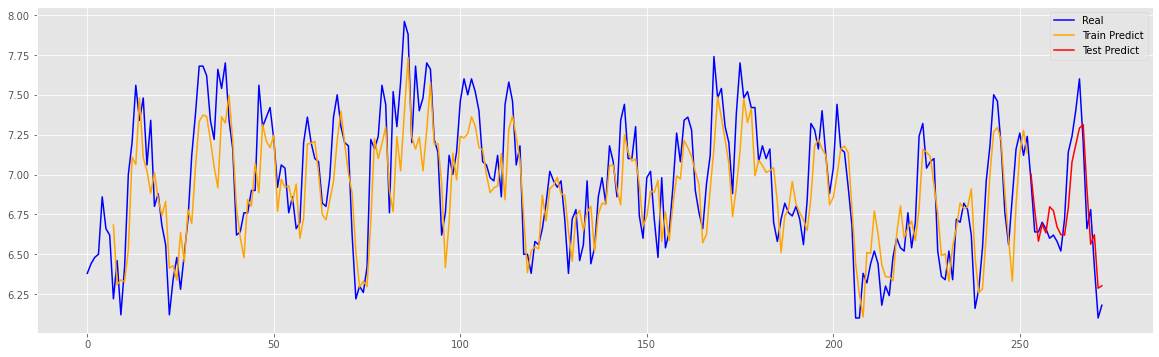

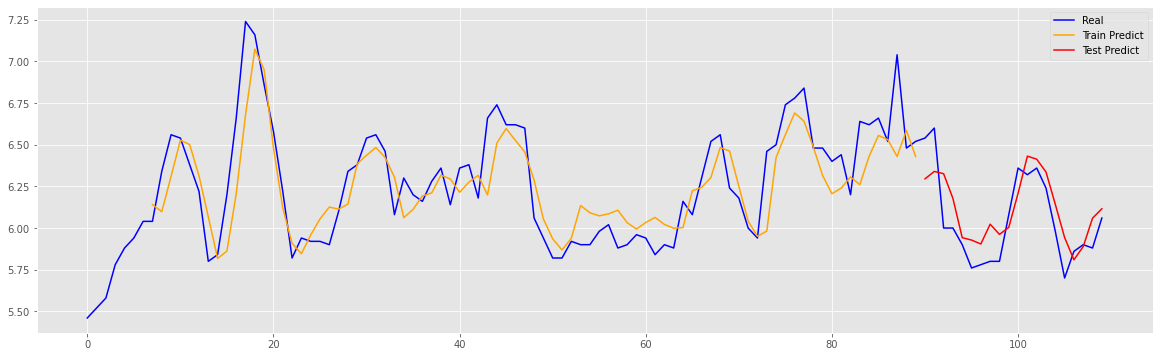

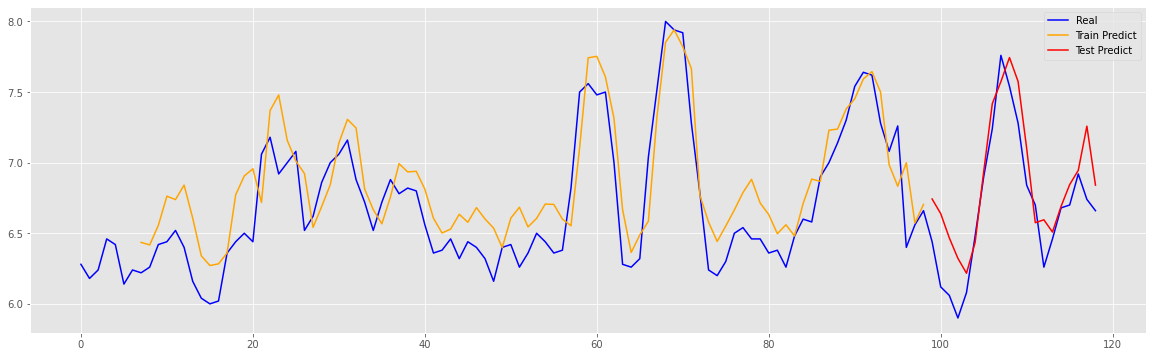

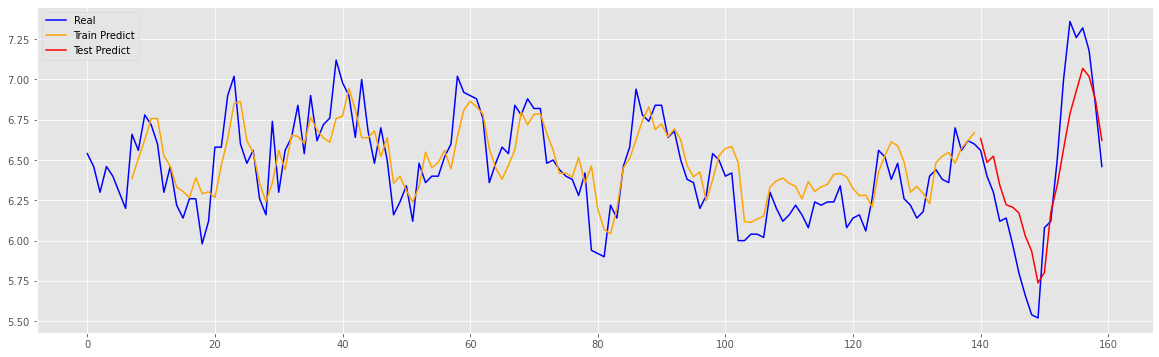

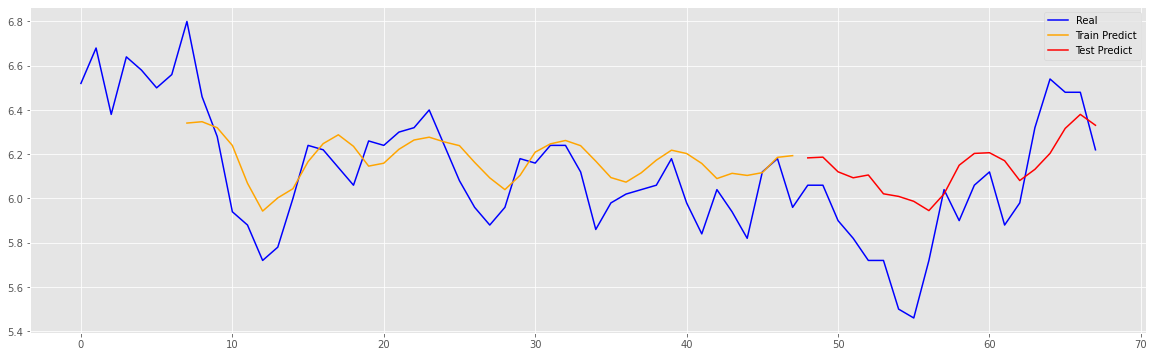

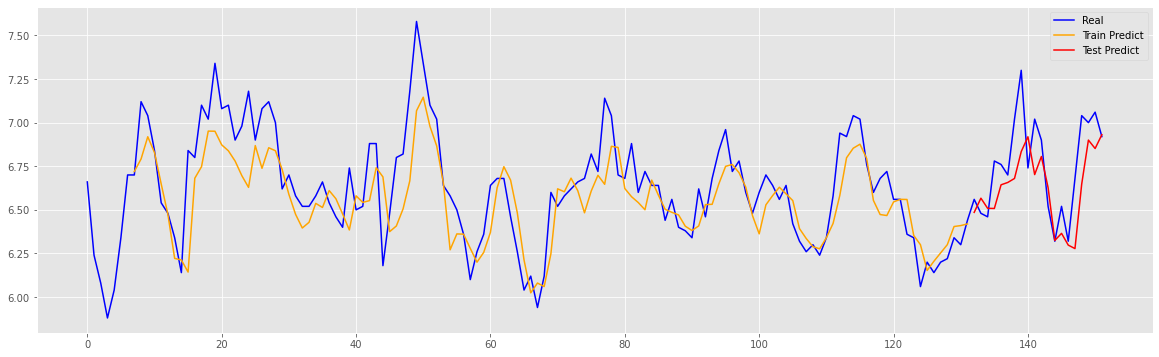

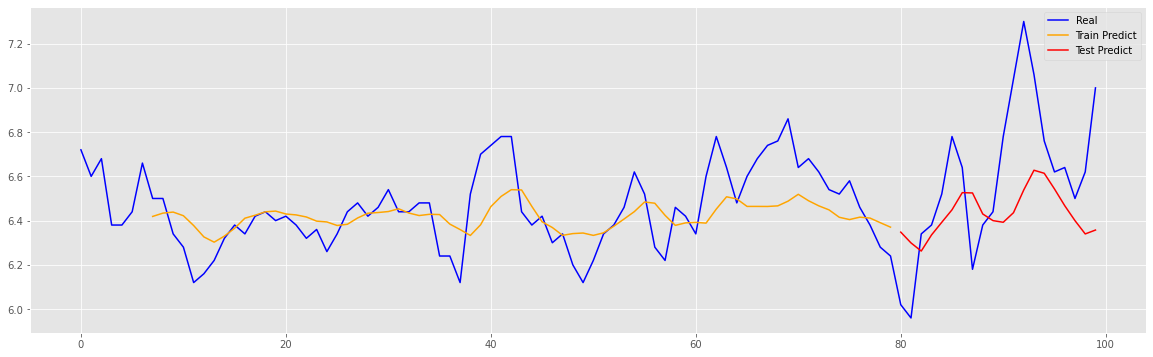

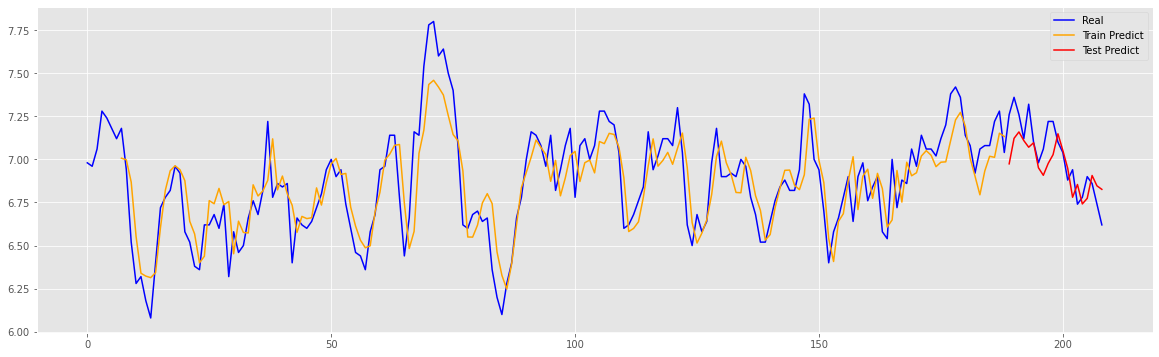

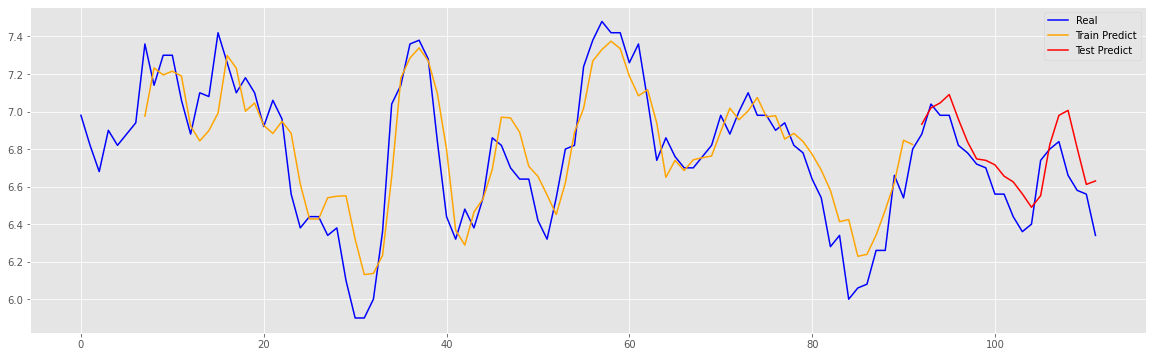

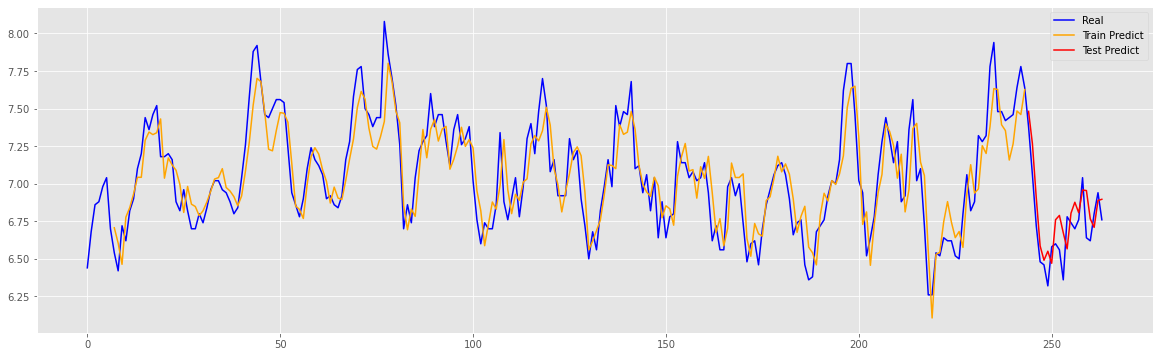

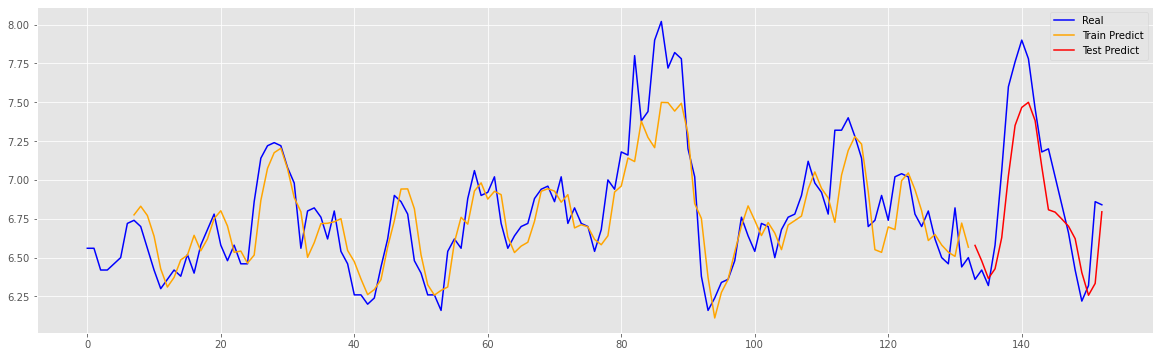

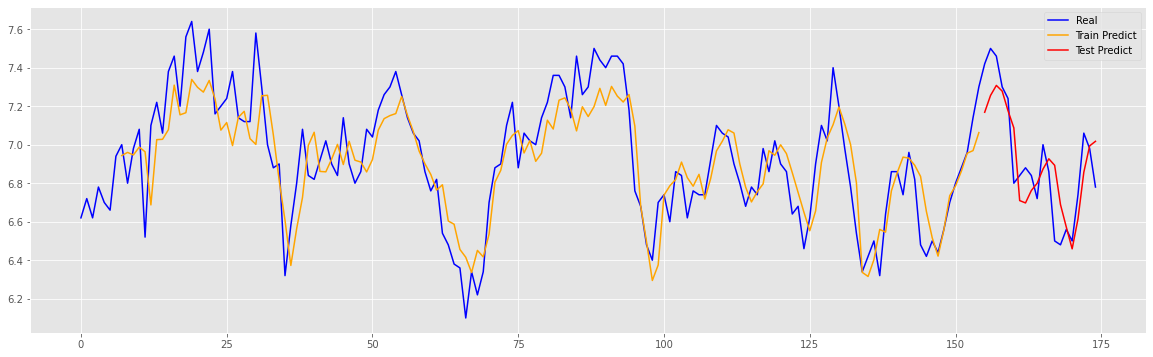

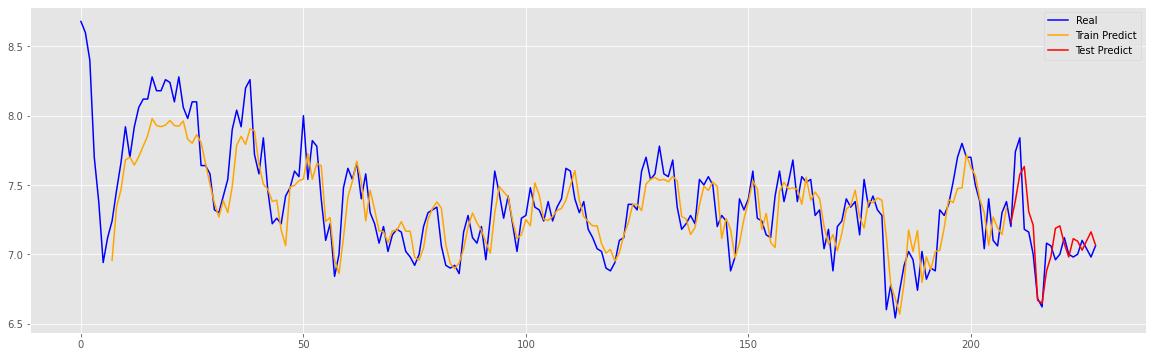

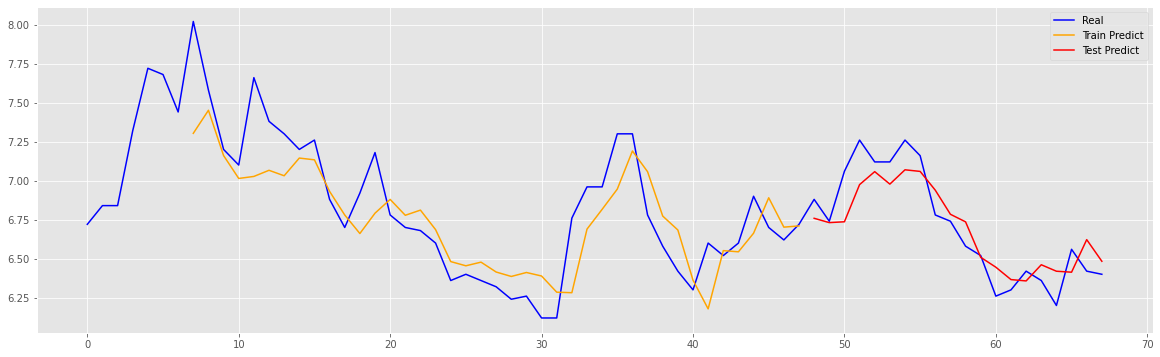

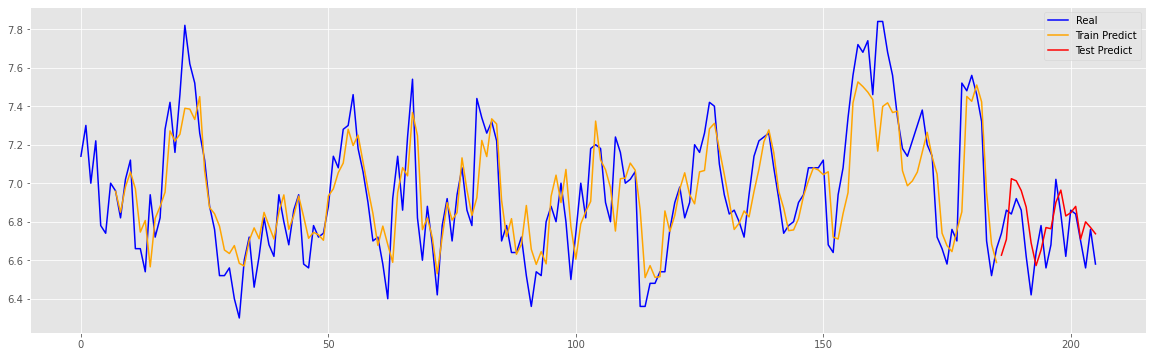

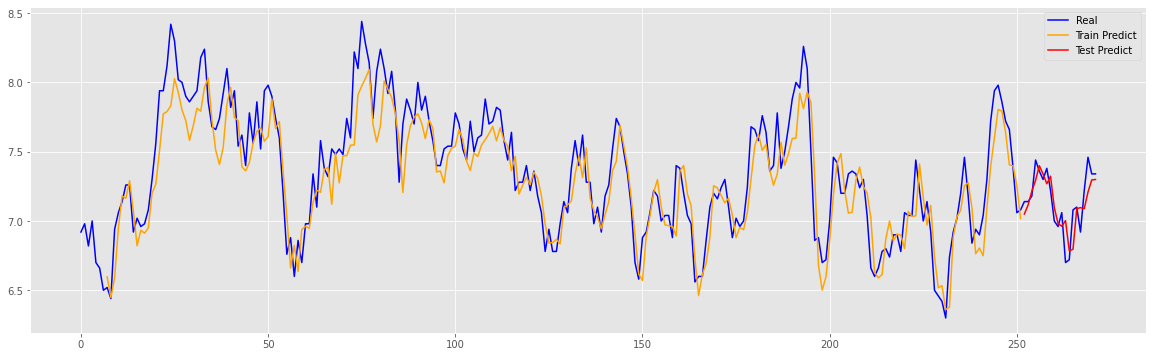

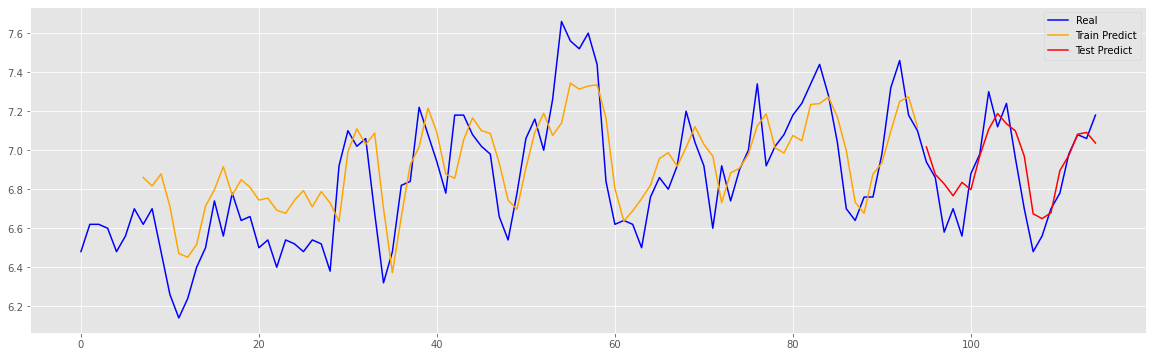

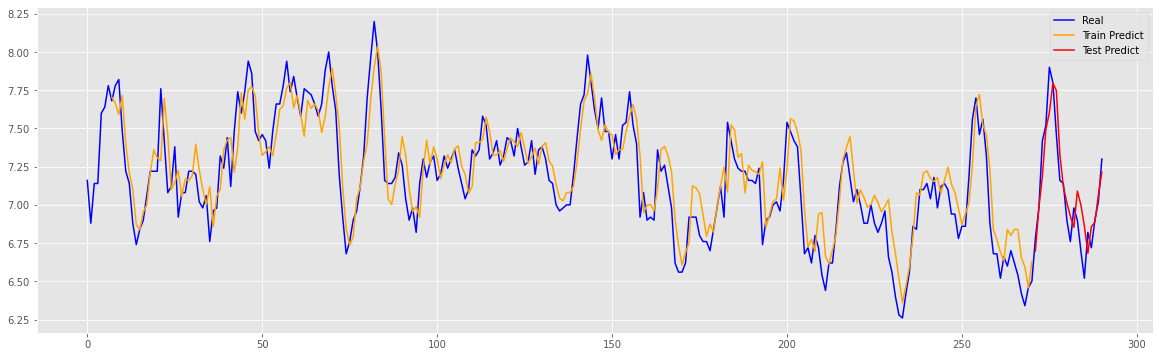

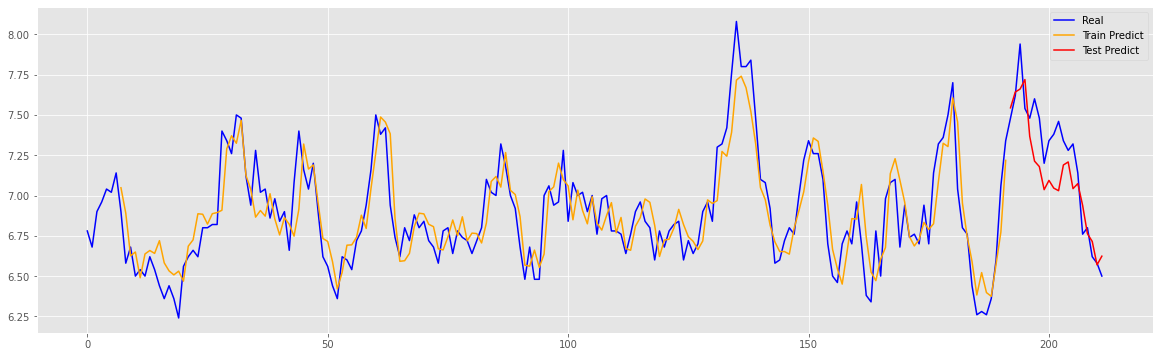

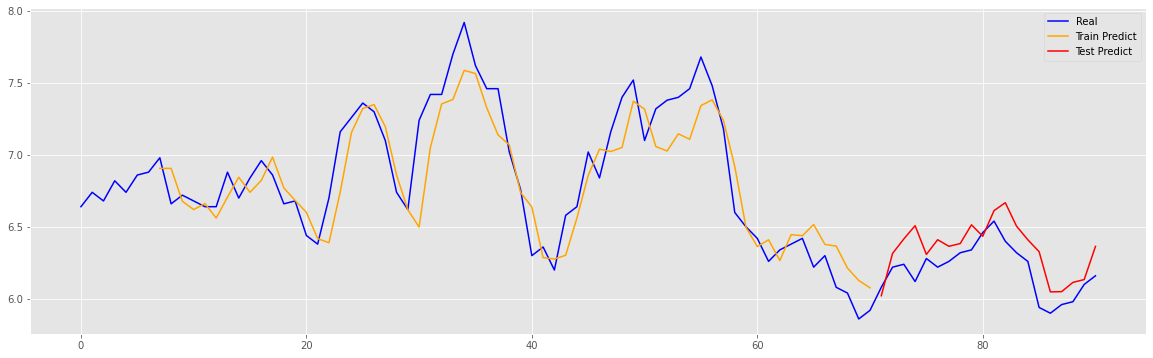

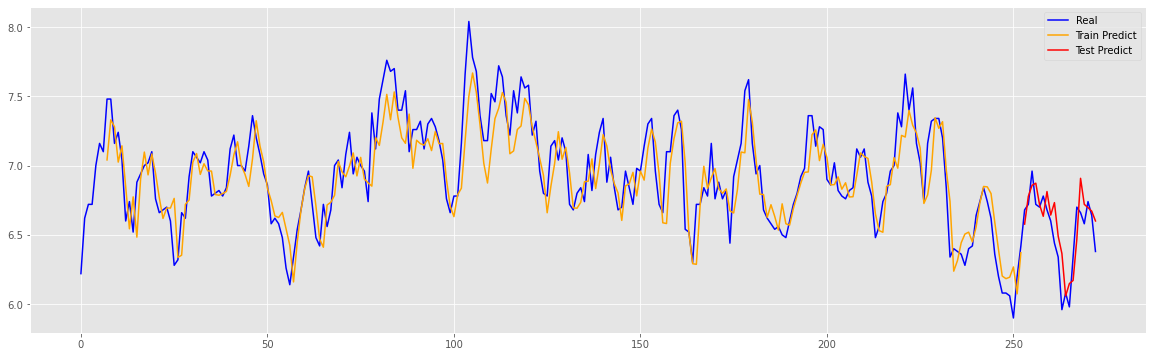

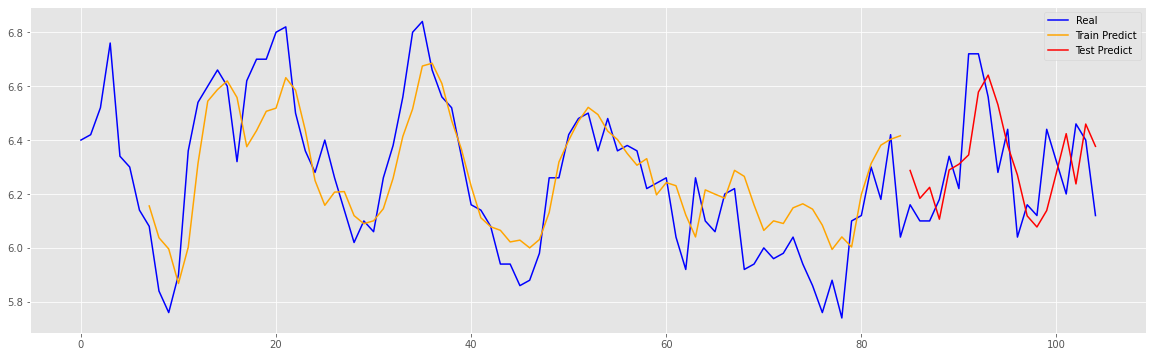

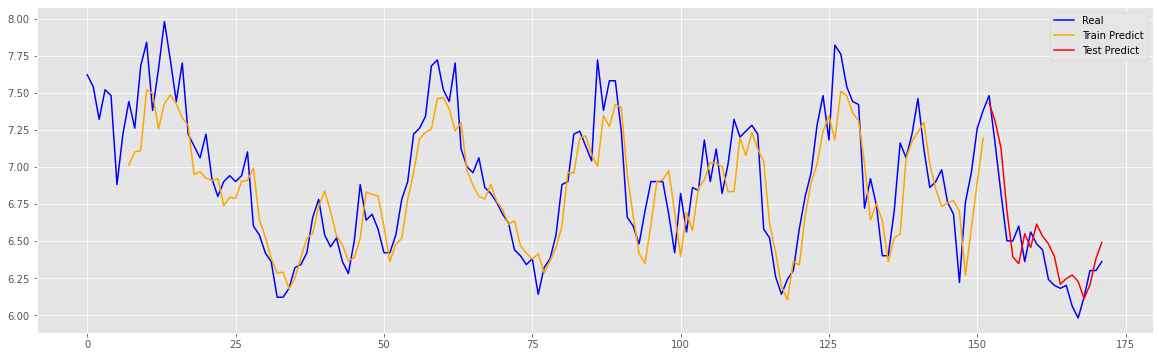

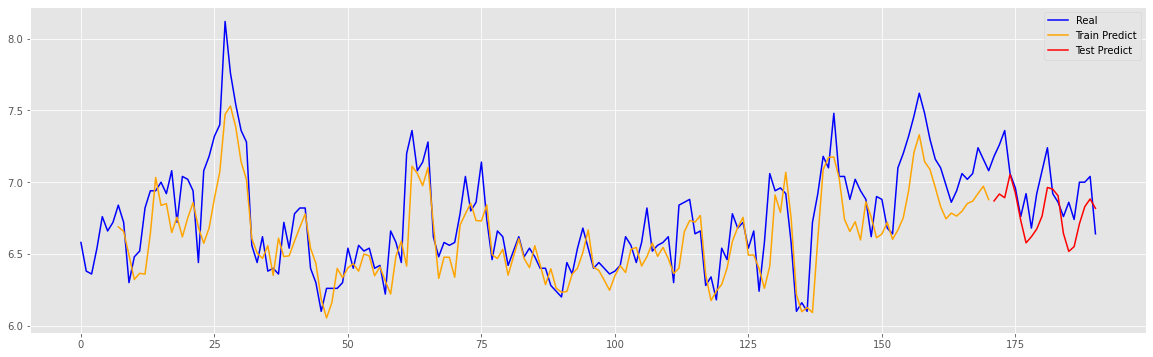

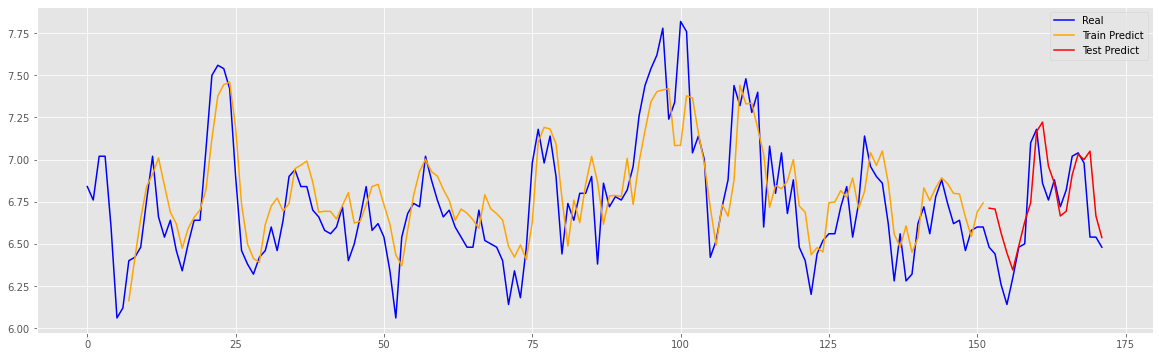

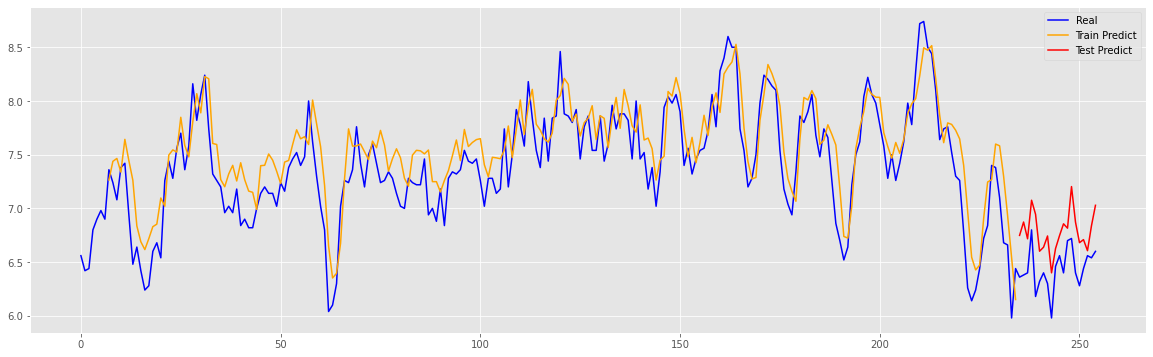

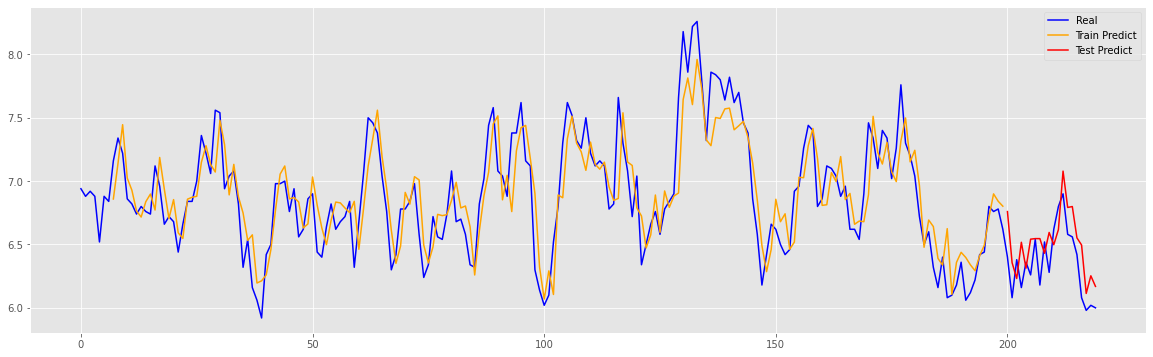

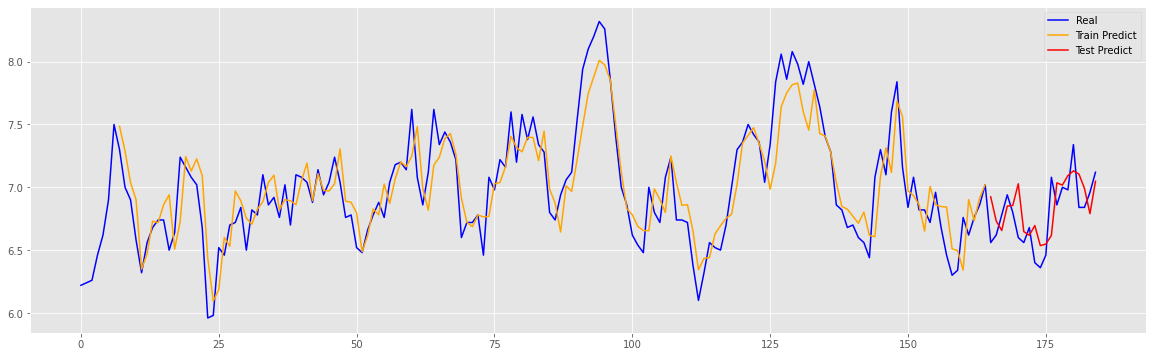

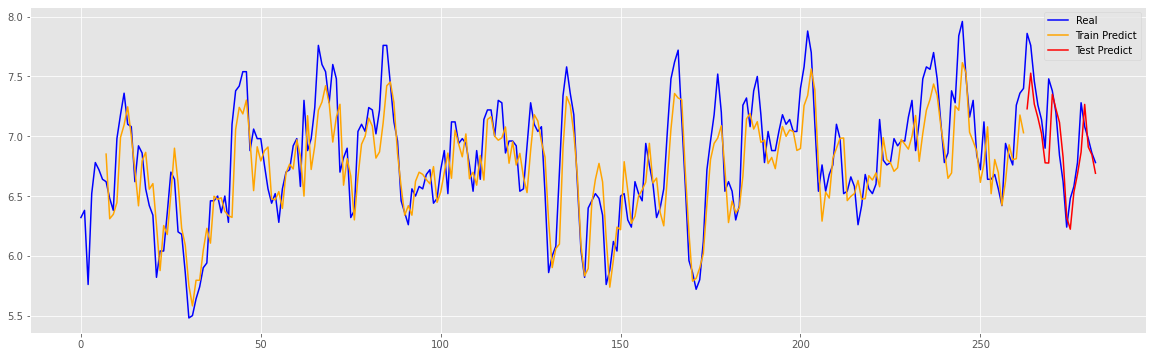

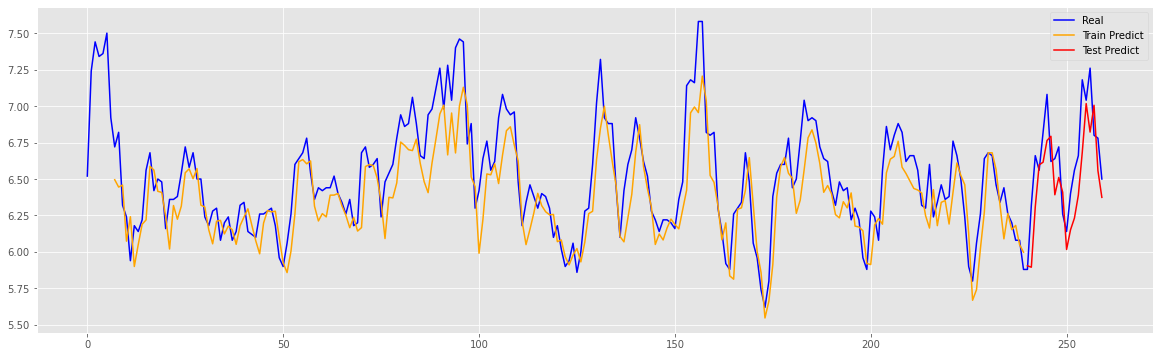

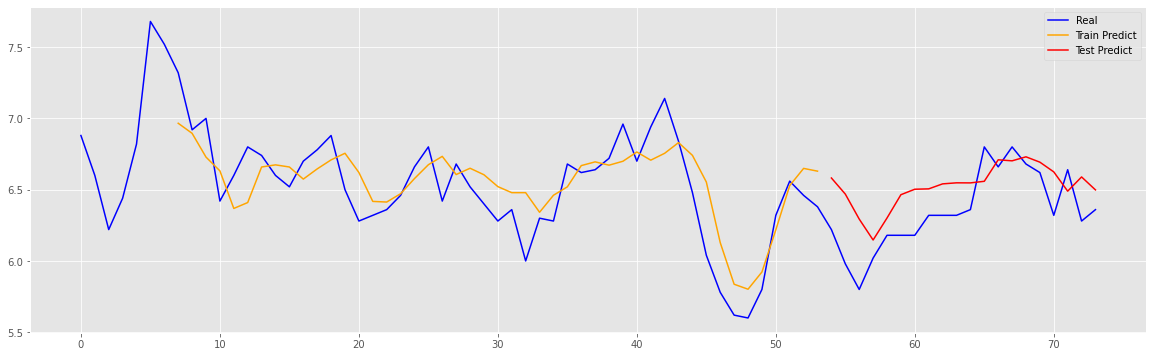

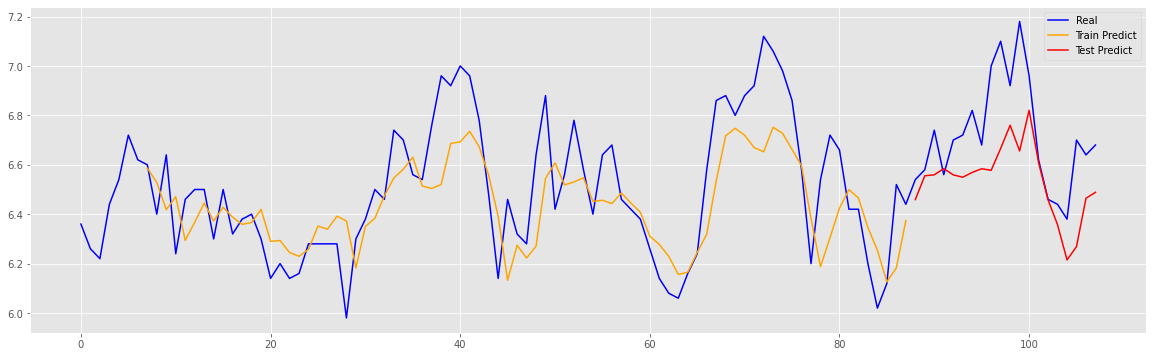

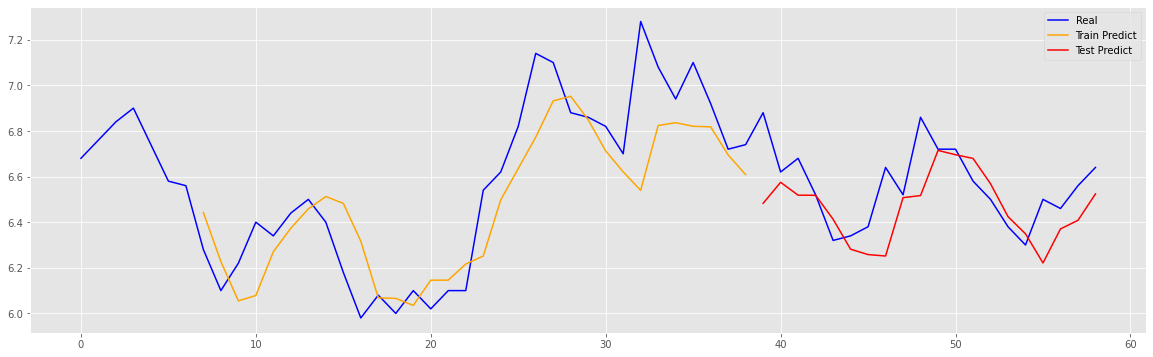

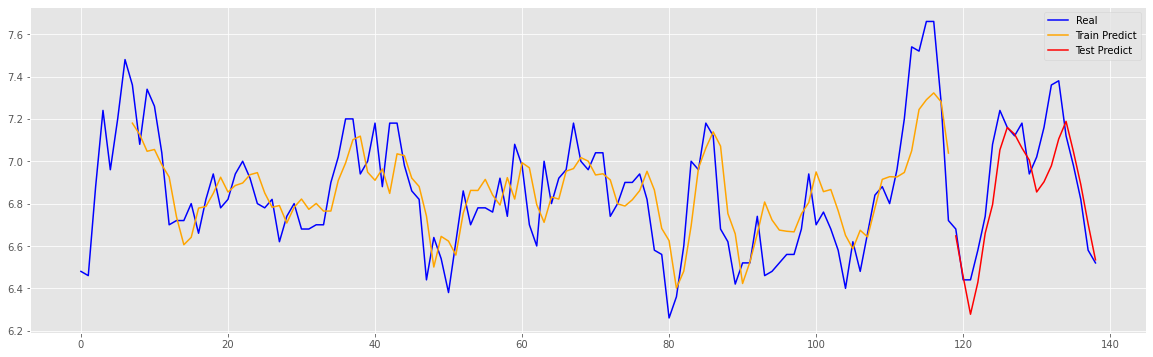

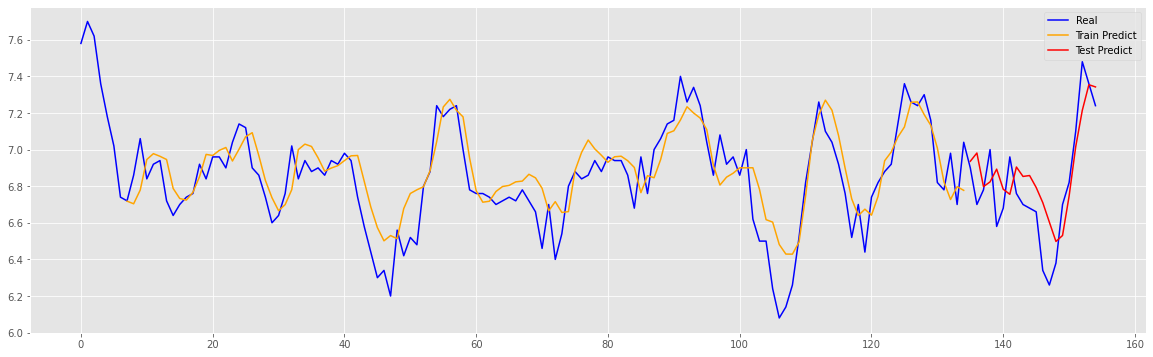

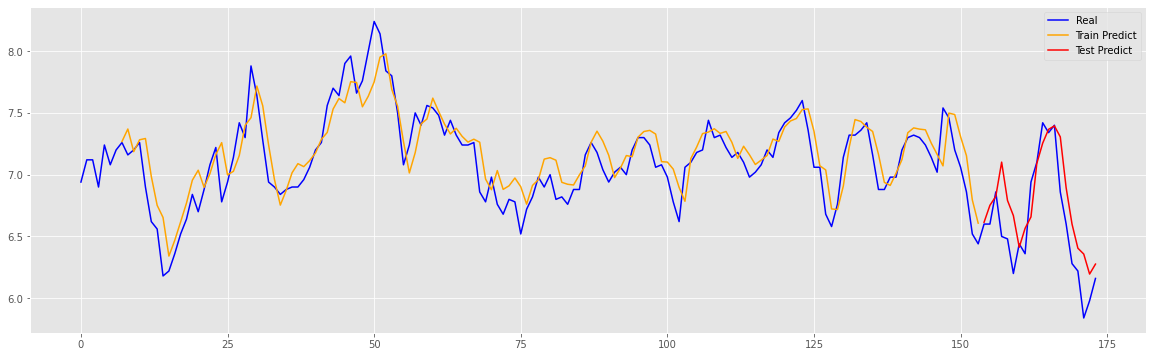

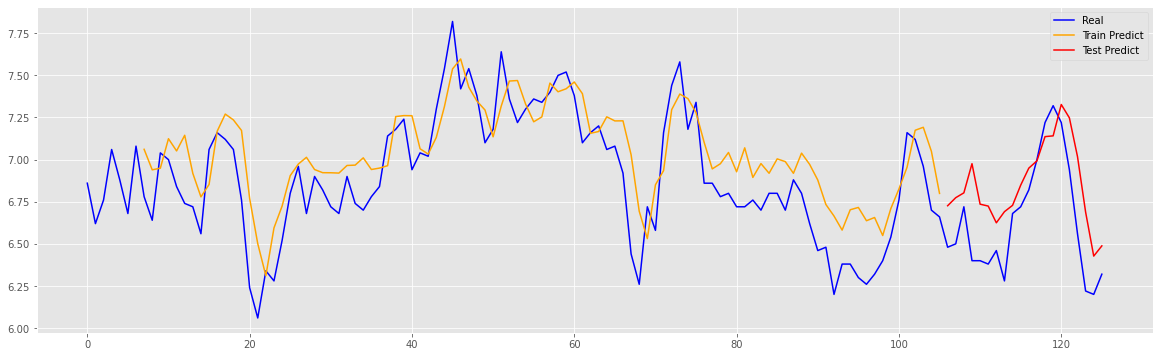

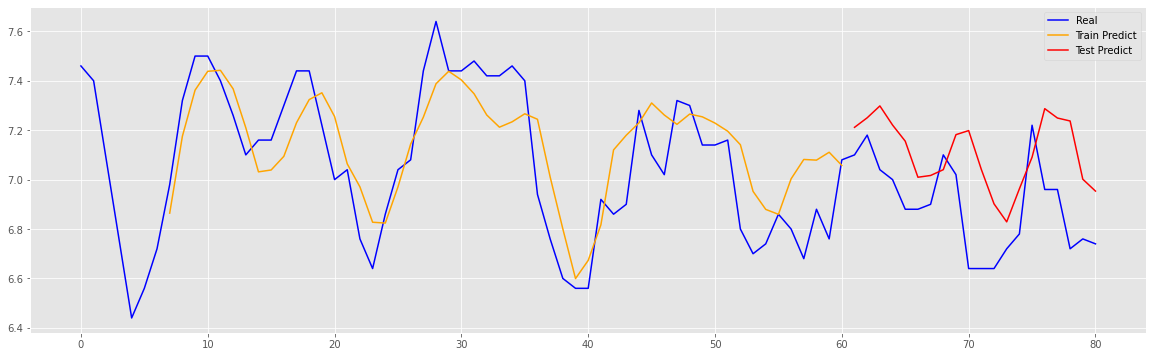

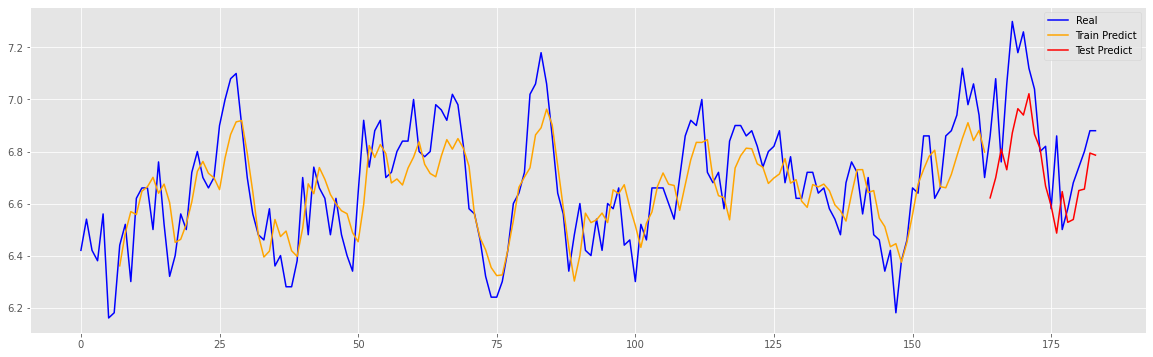

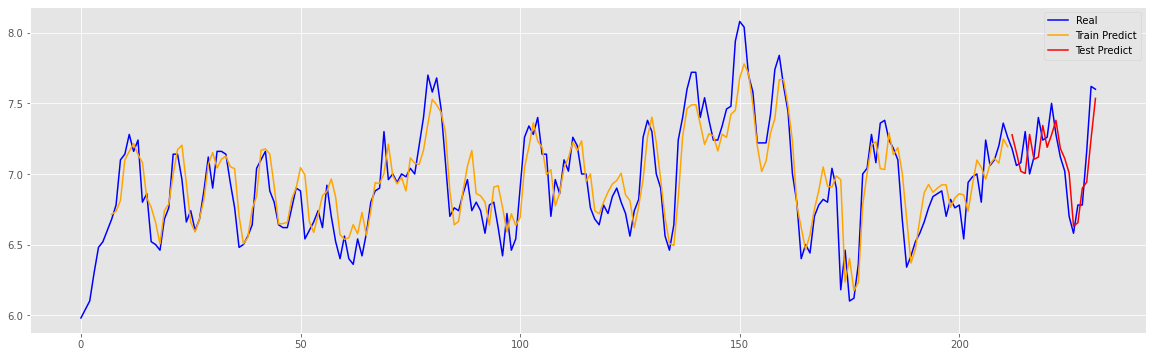

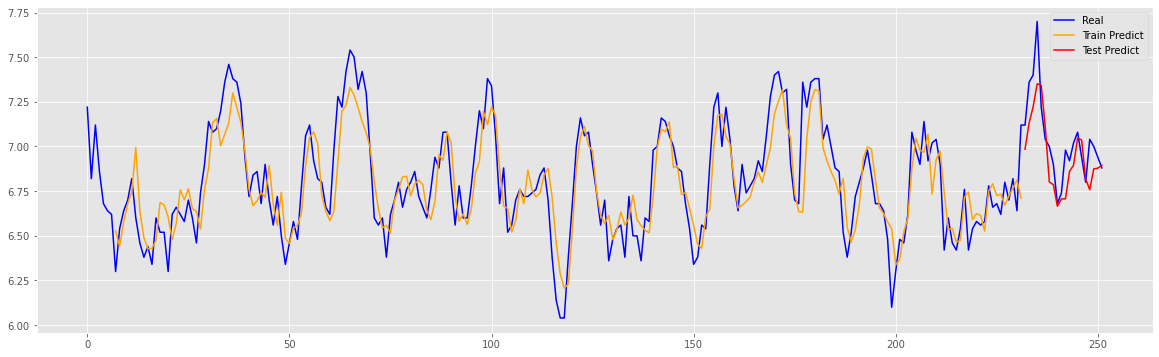

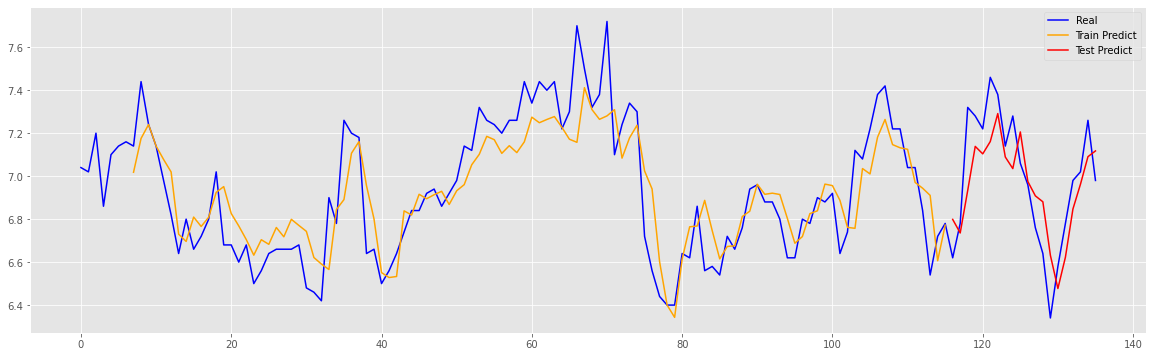

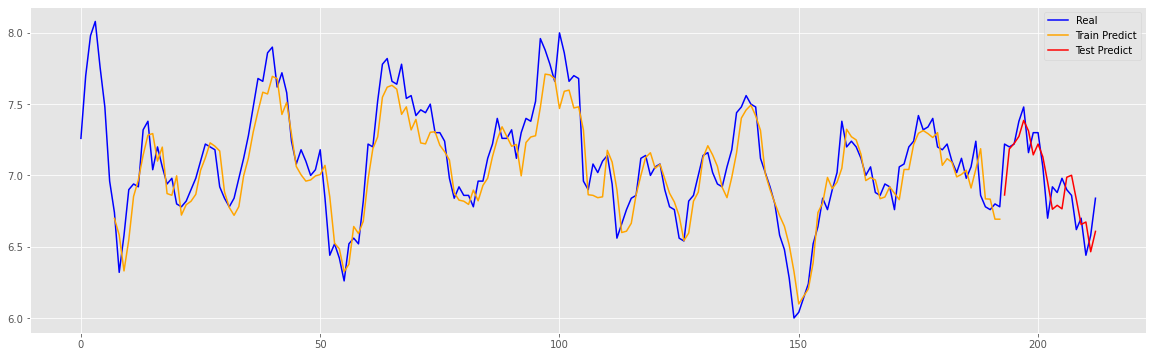

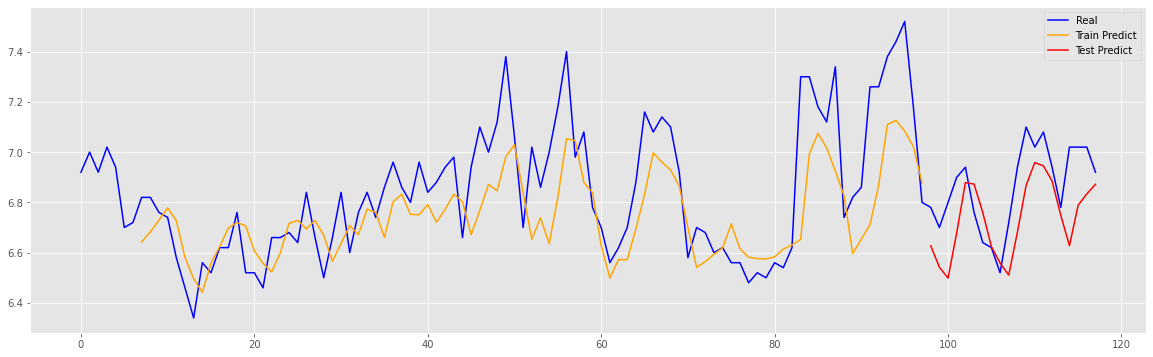

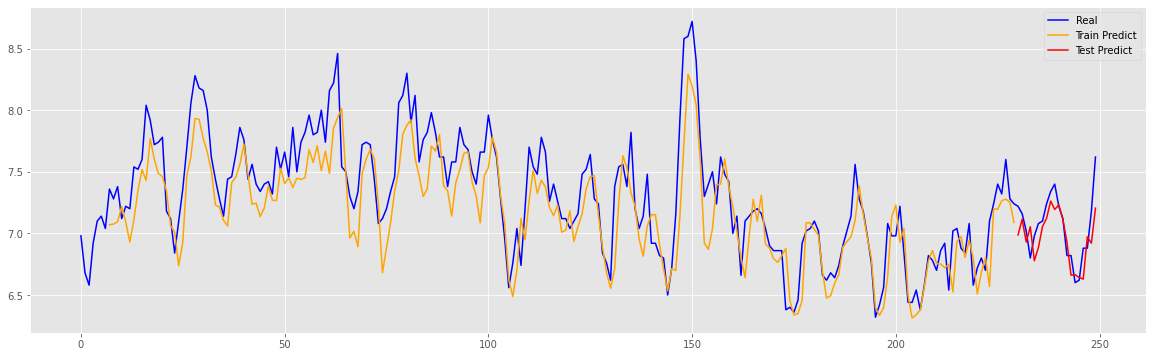

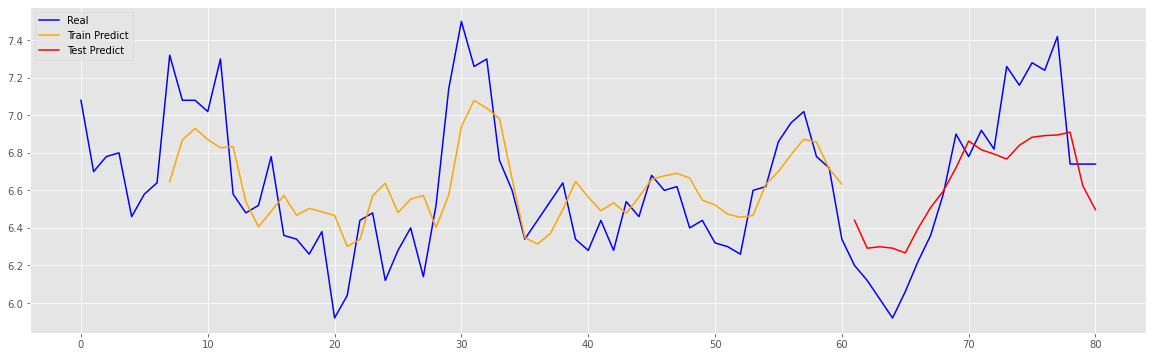

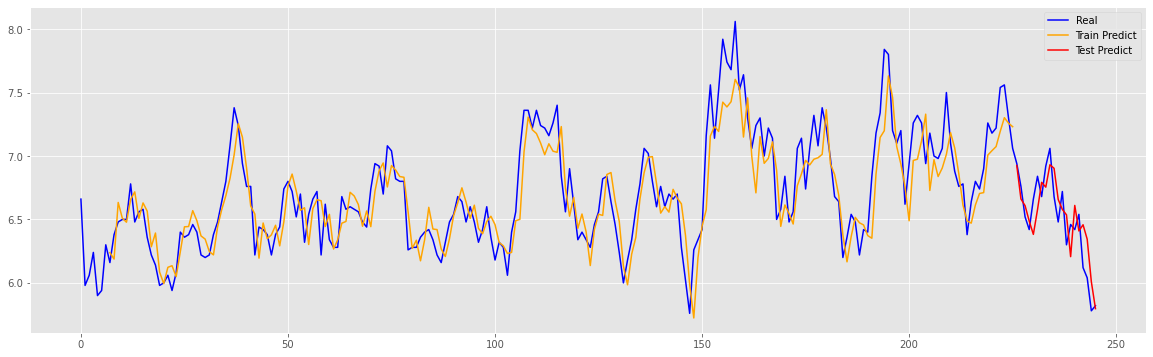

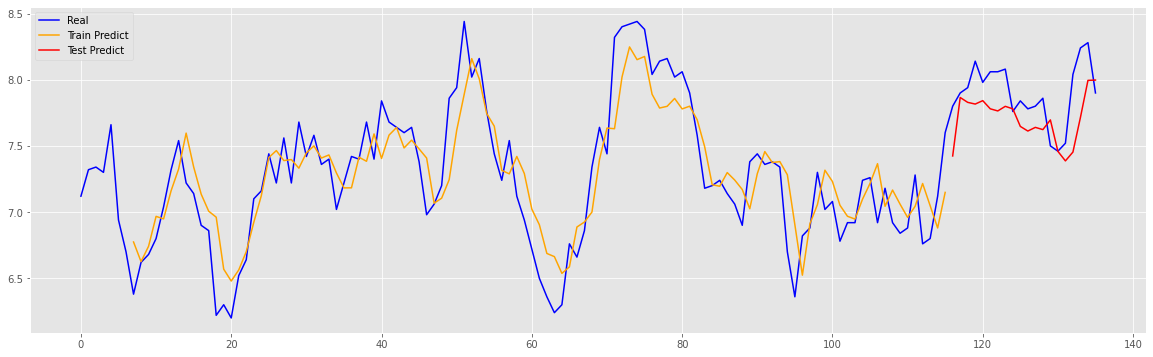

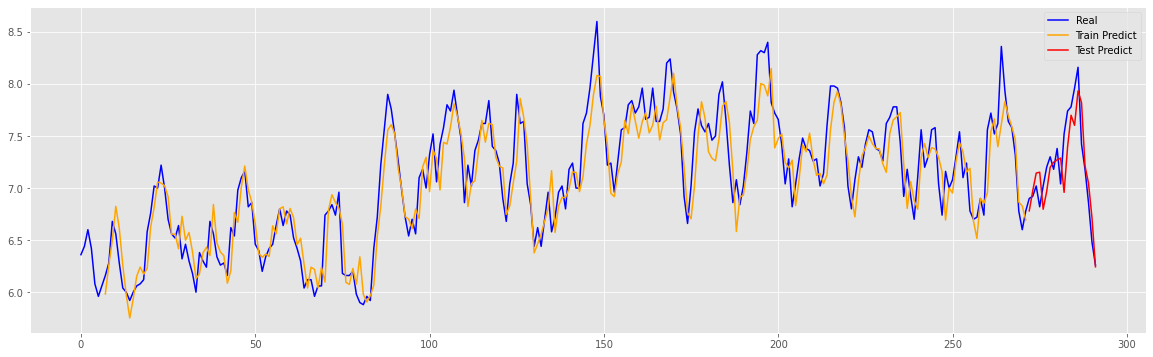

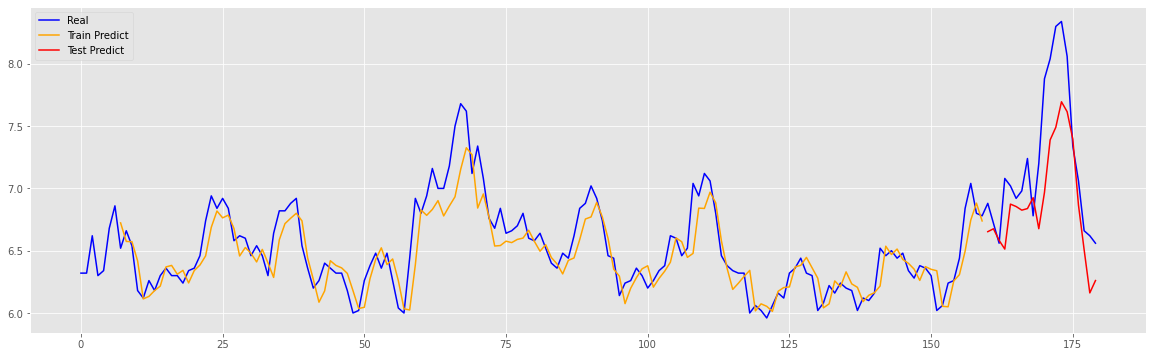

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
plt.style.use("ggplot")

for player_id in tqdm(dict_player.keys()):
  print('Read File......')
  df_result = pd.read_csv(Filename, dtype={"name": str,"id": int,"mae": float,"mse": float,"rmsle": float,"r2": float})
  print('Current Length:' + str(len(df_result)))
  print('Now working on player: '+dict_player_name[player_id])
  if(player_id in df_result['id'].values.tolist()):
    print(' Record exist, skipping....')
    continue
  data = dict_player[player_id]
  data_seq,result_seq = create_inout_sequences(data, TIME_STEP)

  train_X = np.array(data_seq[:-TEST_DATA_SIZE])
  test_X = np.array(data_seq[-TEST_DATA_SIZE:])
  train_Y = np.array(result_seq[:-TEST_DATA_SIZE])
  test_Y = np.array(result_seq[-TEST_DATA_SIZE:])

  train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))

  print('Data size:'+str(len(data_seq)))

  model = Sequential()
  model.add(LSTM(NUM_NODES, input_shape=(1, TIME_STEP)))
  model.add(Dense(DENSE))
  model.compile(loss='mean_squared_error', optimizer=sgd)
  model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=1, verbose=0)

  trainPredict = model.predict(train_X)
  testPredict = model.predict(test_X)

  mae = mean_absolute_error(test_Y, testPredict)
  mse = mean_squared_error(test_Y, testPredict)
  r2 = r2_score(test_Y, testPredict)
  rmsle_v = rmsle(test_Y, testPredict)

  plt.figure(figsize=[20,6])
  plt.plot(range(0,len(data)),data,color='blue')
  len_trainP = len(trainPredict[:,0])
  len_testP = len(testPredict[:,0])
  plt.plot(range(TIME_STEP,TIME_STEP+len_trainP),trainPredict[:,0],color='orange')
  plt.plot(range(TIME_STEP+len_trainP,TIME_STEP+len_trainP+len_testP),testPredict[:,0],color='red')
  plt.legend(['Real', 'Train Predict', 'Test Predict'],loc='best')
  plt.savefig('./' + Foldername + '/' + str(player_id) + '.jpg')
  #plt.show()

  print('\tmae:'+str(mae))
  print('\tmse:'+str(mse))
  print('\tr2:'+str(r2))
  print('\trmsle:'+str(rmsle_v))
  df_result = df_result.append({'name':dict_player_name[player_id],\
        'id':player_id,\
        'mae':mae,\
        'mse':mse,\
        'r2':r2,\
        'rmsle':rmsle_v[0]},ignore_index='true')
  df_result.to_csv(Filename,index=0)